Runcorn 1979 Physics of the Earth and Planetary Interiors vol. 20 p1-5
Reproduce Runcorn's Figure 1, showing the number of days per lunar (synodic) month
as a function of the semimajor axis of the Moon

In [1]:
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.integrate import odeint

plt.rc("axes", lw = 1.5)
plt.rc('xtick.major', size = 8.0)
plt.rc('ytick.major', size = 8.0)
plt.rc('xtick.minor', size = 4.0)
plt.rc('ytick.minor', size = 4.0)
mpl.rcParams['xtick.major.top'] = True
label_fontsize = 15

In [2]:
#Relevant astronomical data, cgs units
#From Yoder (1995)
G = 6.672e-8
# Earth
#
mean_Earth_radius = 6.371e8      # cm
M_Earth = 5.9736e27              # grams
I_Earth_mean_constant = 0.32997  #I = this constant times M r**2
k_2_Earth = 0.298 #Mathews et al (1995) JGR 100 9935
omega_Earth = 2. * np.pi / 86164.  #Sidereal day length, since we want to work in an inertial frame
I_Earth = I_Earth_mean_constant *M_Earth * mean_Earth_radius**2
L_Earth = I_Earth * omega_Earth
sidereal_year_in_SI_days = 365.25636
year_in_seconds = 365.25636 * 24. * 3600. 
d_sidereal = 86164.                 # Sidereal day in seconds
#
# The moon
#
M_moon = 7.349e25                # grams
mean_Moon_radius = 1.73753e8     # cm
I_Moon_mean_constant = 0.3935
k_2_moon = 0.0302
Q_moon = 26.5
a_moon_cgs_0 = 3.844e10
a_dot_0 = 3.82 * 1.e6  #cm/yr * yr/Myr, from Dickey et al. (Science) 1994
a_dot_0_cgs = 3.82 / year_in_seconds
synodic_months_per_year_present = 12.37
anomalistic_month_days = 27.55 #current value
mu = G*( M_Earth + M_moon)
L_moon = M_moon * np.sqrt(mu * a_moon_cgs_0)
L_Moon_0 = L_moon
#
# Calculate the current Lunar torque
Torque_Moon = 0.5 * a_dot_0_cgs / a_moon_cgs_0 * L_moon
Torque_Moon_0 = Torque_Moon
Torque_MacDonald = 3.9e23 * 3.8/3.2  #From MacDonald (1964) Rev. Geophysics 
                                     # p 483 eqn. 61; he calculated \dot a = 3.2cm/yr, 3.8cm/yr is observed

print(a_moon_cgs_0/mean_Earth_radius, 'compare to Williams below')
print('Current value of the Lunar torque = %.2e' % Torque_Moon)
print('MacDonald\' value of the Lunar torque, adjusted = %.2e' % Torque_MacDonald)
print('L_moon/L_Earth = ', L_moon / L_Earth)
print('%e' %year_in_seconds)

60.335897033432744 compare to Williams below
Current value of the Lunar torque = 4.56e+23
MacDonald' value of the Lunar torque, adjusted = 4.63e+23
L_moon/L_Earth =  4.960681570889236
3.155815e+07


In [3]:
a_dot_0_cgs

1.2104638770140227e-07

index_24 =  400


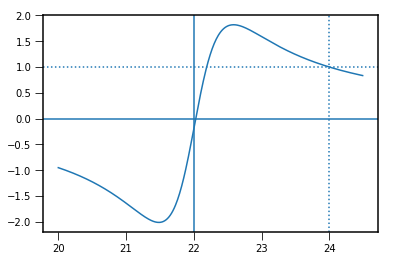

In [4]:
#Resonance model
def resonance(rotation_period, omega_0 = 2. * np.pi/(3600. *22.), Q_thermal = 10.):
    #omega_0 = 2. * np.pi / (3600. * 22.)  #P_res = 22 hours is from Hanbo resonant spin
    #Q_thermal = 10.  From Hanbo as well
    Gamma = omega_0/Q_thermal
    omega = 2. * np.pi / (3600. * rotation_period)
    A_top = 4.* omega * (omega**2 - omega_0**2) + omega * Gamma**2
    A_bottom = 4. * (omega**2 - omega_0**2)**2 + omega**2 * Gamma**2
    Amplitude  = -A_top / A_bottom
    #Find the index corresponding to a 24 hour period
    index_24 = np.where(rotation_period - 24. > 0)[0][0]
    print('index_24 = ', index_24)
    #Amplitude = Torque_Moon / 16. * Amplitude/ Amplitude[index_24]
    Amplitude =  Amplitude/ Amplitude[index_24]
    return(Amplitude)

rotation_period = np.arange(20., 24.5, 0.01)

P_0 = 22. #in hours
omega_0 = 2. * np.pi / (3600. * P_0)
Q_test = 10.
test_resonance = resonance(rotation_period, omega_0, Q_test)
fig, ax = plt.subplots()
plt.plot(rotation_period, test_resonance)
plt.axhline(1., ls =':')
plt.axvline(24, ls = ':')
plt.axvline(P_0)
plt.axhline(0)
plt.show()

In [5]:
#Calculate Q from the measured \dot a
#From MacDonald (1964)
A_MacDonald = 1.5 * G * M_moon * mean_Earth_radius**5 * k_2_Earth  #eqn 26
mu = G*( M_Earth + M_moon)
Q_measured = 2. * A_MacDonald /(np.sqrt(mu) * a_moon_cgs_0**(11./2) * a_dot_0_cgs)
Q_0 = Q_measured
#
print('Q = ', Q_measured, 'A =', A_MacDonald, 'MacDonald gets in Table 1, 2.313e62')

Q =  11.500008890726773 A = 2.300540236839369e+62 MacDonald gets in Table 1, 2.313e62


In [6]:
#define a function to calculate da/dt given Q and a
def da_dt(a, Q, A):
    da_dt = 2. * A / np.sqrt(mu) / a**(11./2.) / Q
    return(da_dt)
    

test = da_dt(a_moon_cgs_0, Q_0, A_MacDonald) * year_in_seconds
print('da_dt now calculated = ', test, year_in_seconds)

def lunar_torque(a, Q, A_MacDonald):
    lunar_torque = M_moon * A_MacDonald /(a**6 * Q)
    return(lunar_torque)

test_current_torque = lunar_torque(a_moon_cgs_0, Q_measured, A_MacDonald)
print('test_current_torque = ', test_current_torque/Torque_Moon)

da_dt now calculated =  3.819999999999999 31558149.504
test_current_torque =  0.9999999999999999


## Use simple tidal theory (e=0) to find the semimajor axis of the Moon in the past

In [7]:
#Find a(T) using tidal theory
def a_of_T(T, Q, a_1, Q_0=11.5, a_0=a_moon_cgs_0):
    # T is a vector (the age in millions of year) starting at T=0 or some earlier (larger number) time
    # a_0 is the initial value of the semimajor axis (at time T=0)
    # a_1 is the value of the semimajor axis at time T[0]
    # Q_0 is the current value of Q (=11.5)
    # Q is the value of Q at T[0] and earlier
    #
    # The current rate of recession of the Moon
    a_dot_0 = 3.82 * 1.e6 #cm/yr * yr/Myr, from Dickey et al. (1994) Science
    # The scaled rate of recession of the Moon in the past
    print('In a_of_T, Q= ', Q, Q_0)
    a_dot_1 = a_dot_0 *(Q_0/Q) * (a_0/a_1)**(11./2.)
    print('In a_of_T, a_dot_1=', a_dot_1)
    T_1 = T[0] - 1.e-10 # Kludge to make sure the initial a is a_1 and not NAN
    #Find when the lunar semimajor axis goes to zero
    test_for_zero = 1. - 13./2. * a_dot_1 / a_1 * (T - T_1)
    #print('test_for_zero=', test_for_zero)
    # The code setting index using np.int returns a numpy array
    #index_when_moon_crashes = np.int(np.where(np.diff(np.signbit( test_for_zero )))[0] )
    # while the code using len retuns a scalar
    # the plotting routines need a scalar, not a numpy array
    test_index = np.where(test_for_zero < 0)
    if (test_index[0].size >0):
        index_when_moon_crashes = np.where(test_for_zero<0)[0][0]
    else:
        index_when_moon_crashes = len(T)
    
    #print('index_when_moon_crashes = ', index_when_moon_crashes)
    #a_of_T = np.zeros(len(T))
    #a_of_T[:index_when_moon_crashes] = a_1 * (test_for_zero[:index_when_moon_crashes])**(2./13.)
    a_of_T = a_1 * (test_for_zero[:index_when_moon_crashes])**(2./13.)
    return((a_of_T, index_when_moon_crashes))

In [8]:
#Find and (in next cell) plot a_lunar(T)
# this is just to test the code
T = np.arange(0, 4000, 1) #Age of deposits, units are millons of years
Q_0 = Q_measured
Q   = Q_measured
a_1 = a_moon_cgs_0
a_T, index_when_crashed = a_of_T(T, Q, a_1)
print('a_T, index= ', a_T[:index_when_crashed], index_when_crashed)
#
#Find the precambrian (defined as T>600 Myrs) and the value of a at that and earlier times
# Need this to plot a dashed line at times before Q decreases---this is only roughly at the star
# of the Cambrian, but I need a name
index_of_precambrian = np.asscalar(np.where(np.diff(np.signbit(T-600)))[0] + 1)
#index_scalar = np.asscalar(index_of_precambrian)
#
#Now set up the Precambrian a(T)
T_precambrian = np.arange(600., 4600, 5)
Q = 40.   # I adjusted this to have the Moon form at a=0 at about 4,600 Mya, probably too early
a_1 = a_T[index_of_precambrian]
#a_1_test = a_T[index_scalar]
a_1_test = a_T[index_of_precambrian]
print('a at cambrian = ', a_1, a_1_test)
print('index_when_crashed', index_when_crashed, a_T[index_when_crashed-1])
a_T_precambrian, index_when_crashed_precambrian = a_of_T(T_precambrian, Q, a_1)
#
T_precambrian = T_precambrian[:index_when_crashed_precambrian]
a_T_precambrian = a_T_precambrian[:index_when_crashed_precambrian]
#Plot in next cell

In a_of_T, Q=  11.500008890726773 11.5
In a_of_T, a_dot_1= 3819997.046734781
a_T, index=  [3.84400000e+10 3.84361790e+10 3.84323558e+10 ... 1.39481152e+10
 1.26508228e+10 9.05591620e+09] 1549
a at cambrian =  35647034631.295876 35647034631.295876
index_when_crashed 1549 9055916198.95236
In a_of_T, Q=  40.0 11.5
In a_of_T, a_dot_1= 1662957.1247271434


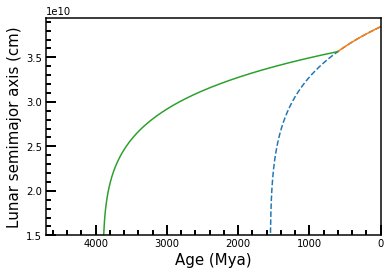

In [9]:
#
# Move on to plotting
#
mpl.rcParams['xtick.major.top'] = True
#
fig, ax = plt.subplots()
#ax.tick_params(direction = 'in')

#xminorLocator = AutoMinorLocator()
#yminorLocator = AutoMinorLocator()
#ax.xaxis.set_minor_locator(xminorLocator)
#ax.yaxis.set_minor_locator(yminorLocator)
#ax.tick_params(direction = 'in')
#
plt.plot(T[:index_when_crashed], a_T[:index_when_crashed], ls='--')
plt.plot(T[:index_of_precambrian], a_T[:index_of_precambrian], ls='-')
#plt.plot(T_precambrian[a_T_precambrian>0], a_T_precambrian[a_T_precambrian>0])
plt.plot(T_precambrian, a_T_precambrian)
plt.xlim(4700.,0)
plt.ylim(1.5e10, a_moon_cgs_0+ 1.e9)
plt.xlabel('Age (Mya)', fontsize = label_fontsize)
plt.ylabel('Lunar semimajor axis (cm)', fontsize = label_fontsize)

ax.minorticks_on()
ax.tick_params(which='major', length=10, width=2, direction='in')
ax.tick_params(which='minor', length=5, width=2, direction='in')
plt.show()
#
#Delete the variables to avoid confusion later on
#
del T, Q, Q_0, a_1, a_T, index_when_crashed, index_of_precambrian,  T_precambrian
del a_T_precambrian, index_when_crashed_precambrian, 

### Create a dictionary to convert from epoch or other geologic name to age in millions of years

In [10]:
epoch_names = ('recent', 'pleistocene', 'pliocene', 'miocene', 'oligocene', 'eocene',\
               'palaeocene', 'cretaceous', 'jurassic', 'triassic', 'permian', \
               'pennsylvanian','carboniferous', 'mississippian', 'devonian', 'silurian', 'ordovician', 'cambrian')
#Times associated with epoch, from the International Commission on Stratigraphy Chronostratigraphic chart
epoch_time_mya = [1., 2.58/2., (5.33+2.58)/2, (23.03+5.33)/2., (33.9+23.03)/2., (56.+33.9)/2., (66.0+56.0)/2.,
                 (145.+66.)/2, (201.3+145.)/2., (251.9+201.3)/2., (298.9+251.9)/2., (323.2+298.9)/2., (358.9+298.9)/2., 
                  (358.9+323.2)/2., (419.2+358.9)/2., (443.8+419.2)/2., (485.4+443.8)/2., (541.0+485.4)/2. ]
print(epoch_names)
print(epoch_time_mya)

('recent', 'pleistocene', 'pliocene', 'miocene', 'oligocene', 'eocene', 'palaeocene', 'cretaceous', 'jurassic', 'triassic', 'permian', 'pennsylvanian', 'carboniferous', 'mississippian', 'devonian', 'silurian', 'ordovician', 'cambrian')
[1.0, 1.29, 3.955, 14.18, 28.465, 44.95, 61.0, 105.5, 173.15, 226.60000000000002, 275.4, 311.04999999999995, 328.9, 341.04999999999995, 389.04999999999995, 431.5, 464.6, 513.2]


In [11]:
#Create a dictionary to convert from epoch name to time in Mya back to the Cambrian
epoch_to_time = dict(zip(epoch_names, epoch_time_mya))

print(epoch_to_time)
#Now associate the time in the middle of each epoch to the name of that epoch
time_general = []
for epoch in epoch_names:
    time_general.append(epoch_to_time[epoch])

#print('check that time_general matches epoch_time_mya')
#print(time_general)
#print(epoch_time_mya)
print('epoch', epoch_names)

{'recent': 1.0, 'pleistocene': 1.29, 'pliocene': 3.955, 'miocene': 14.18, 'oligocene': 28.465, 'eocene': 44.95, 'palaeocene': 61.0, 'cretaceous': 105.5, 'jurassic': 173.15, 'triassic': 226.60000000000002, 'permian': 275.4, 'pennsylvanian': 311.04999999999995, 'carboniferous': 328.9, 'mississippian': 341.04999999999995, 'devonian': 389.04999999999995, 'silurian': 431.5, 'ordovician': 464.6, 'cambrian': 513.2}
epoch ('recent', 'pleistocene', 'pliocene', 'miocene', 'oligocene', 'eocene', 'palaeocene', 'cretaceous', 'jurassic', 'triassic', 'permian', 'pennsylvanian', 'carboniferous', 'mississippian', 'devonian', 'silurian', 'ordovician', 'cambrian')


## Collect all the data 
from corals, bivalves, brachiopods, stromatolites, and tidal Rhythmites


In [12]:
#Wells (1963) Nature 197 948
Wells_epoch = ('devonian', 'pennsylvanian', 'pennsylvanian')
Wells_time = []
for epoch in Wells_epoch:
    Wells_time.append(epoch_to_time[epoch])

Wells_days_per_year = np.array([400, 390, 385])
Wells_days_per_year_error = np.array([10, 5, 5])

In [13]:
#Plot lunar days, since we are looking at tides
#Williams assumes that only gravitational tides matter for all but the last two entries in his table,
#an assumption that we don't want to make, so for the plot of days per month, we will just use
#those two, Elatina and present day
#x = r/r_0, s is the number of solar days per synodic month, s' is the number of lunar days per synodic month
x_williams_age = np.array([0.1, (635. + 650.)/2.])
x_williams_age_error = np.array([0., 7.5])
x_williams = np.array([60.27, 58.16])
x_williams = x_williams/x_williams[0]
s_solar_days_per_synodic_month_williams = np.array([29.53, 30.5])
s_solar_days_per_synodic_month_williams_error = np.array([0.01, 0.5])
s_prime_lunar_days_per_synodic_month_williams = np.array([28.53, 29.5])
s_prime_lunar_days_per_synodic_month_williams_error = np.array([0.01, 0.5])

In [14]:
# Sonett et al. 1996 Science 274 1068
# Sonett and Chan 1998
Sonett_1996_age = np.array([900])
Sonett_1996_age_error = np.array([100])
Sonett_1996_synodic_months_per_year = np.array([13.47])
Sonett_1996_synodic_months_per_year_error = np.array([0.1]) #Half the difference between their two estimates
Sonett_1998_age = np.array([900])
Sonett_1998_solar_days_per_month = np.array([32.4]) #Taken from Williams 2000

In [15]:
#Williams (1989) Episodes vol. 12 single data point from his table 1
Williams_1989_Elatina_age = np.array([650.])
Williams_1989_Elatina_lunar_months_per_year = np.array([13.1])
Williams_1989_Elatina_lunar_months_per_year_error = np.array([0.1])
#
#From Williams (2000) table 1 except age, 
#from http://dbforms.ga.gov.au/pls/www/geodx.strat_units.sch_full?wher=stratno=6029
#
Williams_2000_Elatina_age = np.array([0.1, (635.+650.)/2]) #The 0.1 is to make the modern point visible on plots
Williams_2000_Elatina_age_error = np.array([0., 7.5])
#
Williams_2000_Elatina_lunar_months_per_year = np.array([12.37, 13.1])
Williams_2000_Elatina_lunar_months_per_year_error = np.array([0.1, .1])
Williams_2000_Elatina_sidereal_months_per_year = np.array([13.37, 14.1])
#
Williams_1989_Elatina_apsidal_period = np.array([8.85, 9.7])
Williams_1989_Elatina_nodal_period   = np.array([18.86, 19.5])
Williams_1989_Elatina_lunar_days_per_synodic_month = np.array([28.53, 29.5])
#to get solar days per month, add one day to the number of lunar days per month
#First the age, from Barley et al. (1997) Nature vol. 385 55 Figure 1
#
Williams_1989_Weeli_Wolli_age = np.array([2449.])
Williams_1989_Weeli_Wolli_age_error = np.array([3])
#
Williams_1989_Weeli_Wolli_synodic_months_per_year = np.array([14.5])
Williams_1989_Weeli_Wolli_mpy_error = np.array([0.5])
Walker_Zahnle_1986_Weeli_Wolli_age = Williams_1989_Weeli_Wolli_age
Walker_Zahnle_1986_Weeli_Wolli_synodic_months_per_year = np.array([15.7])
Walker_Zahnle_1986_Weeli_Wolli_mpy_error = np.array([1.1])

In [16]:
Walker_Zahnle_1986_Weeli_Wolli_synodic_months_per_year

array([15.7])

In [17]:
#Post-Cambrian Data from Pannella (1972) Aph. & Sp. Sc. 16 2-1-237
Pannella_Aph_Sp_Sc_1972_table_I_pennsylvanian = ('pennsylvanian', 'pennsylvanian', 'pennsylvanian', \
                                                 'pennsylvanian', 'pennsylvanian')
Pannella_Aph_Sp_Sc_1972_table_I_pennsylvanian_time = []
for epoch in Pannella_Aph_Sp_Sc_1972_table_I_pennsylvanian:
    Pannella_Aph_Sp_Sc_1972_table_I_pennsylvanian_time.append(epoch_to_time[epoch])

Pannella_Aph_Sp_Sc_1972_table_I_pennsylvanian_days_per_synodic_month = np.array([30.65, 29.96, 29.87, 30.16, 30.22])
Pannella_Aph_Sp_Sc_1972_table_I_pennsylvanian_days_per_year = np.array([389., 381.5, 380., 383., 0.])
#
Pannella_Aph_Sp_Sc_1972_table_I_pennsylvanian_days_per_year_average = \
     np.mean(Pannella_Aph_Sp_Sc_1972_table_I_pennsylvanian_days_per_year[:3])
Pannella_Aph_Sp_Sc_1972_table_I_pennsylvanian_days_per_year_error = \
     np.std(Pannella_Aph_Sp_Sc_1972_table_I_pennsylvanian_days_per_year[:3])
#
Pannella_Aph_Sp_Sc_1972_table_I_pennsylvanian_months_per_year_derived = \
Pannella_Aph_Sp_Sc_1972_table_I_pennsylvanian_days_per_year\
/Pannella_Aph_Sp_Sc_1972_table_I_pennsylvanian_days_per_synodic_month
#Note the next-to-last is an overall average, and is listed in Scrutton (1978)
#
Pannella_Aph_Sp_Sc_1972_table_I_mississippian = ('mississippian', 'mississippian', 'mississippian')
Pannella_Aph_Sp_Sc_1972_table_I_mississippian_time = []
for epoch in Pannella_Aph_Sp_Sc_1972_table_I_mississippian:
    Pannella_Aph_Sp_Sc_1972_table_I_mississippian_time.append(epoch_to_time[epoch])

Pannella_Aph_Sp_Sc_1972_table_I_mississippian_days_per_synodic_month = np.array([30.27, 30.46, 30.37])
Pannella_Aph_Sp_Sc_1972_table_I_mississippian_days_per_year = np.array([399., 397., 398.])
#
Pannella_Aph_Sp_Sc_1972_table_I_mississippian_days_per_year_average = \
   np.mean(Pannella_Aph_Sp_Sc_1972_table_I_mississippian_days_per_year)
Pannella_Aph_Sp_Sc_1972_table_I_mississippian_days_per_year_error = \
   np.std(Pannella_Aph_Sp_Sc_1972_table_I_mississippian_days_per_year)
#
Pannella_Aph_Sp_Sc_1972_table_I_mississippian_months_per_year_derived =\
Pannella_Aph_Sp_Sc_1972_table_I_mississippian_days_per_year/ Pannella_Aph_Sp_Sc_1972_table_I_mississippian_days_per_synodic_month

In [18]:
# Pannella 1972 International Geographical Congress 24th section 1 Precambrian Stromatolites as Paleontological Clocks
Pannella_IGC_1972_epoch = ('great slave', 'biwabik', 'belt')
Pannella_IGC_1972_age = np.array([2000, 1635., 950])  
#2000 is consistent with Baadsgaard et al. (1973) Can. J. Earth Sci. 10 1579 (>1872Mya)
#Faure & Kovach (1969) Geo. Soc. Am. Bulletin v. 80 1725 give 1635 for Biwabik
Pannella_IGC_1972_days_per_month = np.array([34., 34., 32.])
Pannella_IGC_1972_months_per_year = np.array([13., 13., 13.])
Pannella_IGC_1972_days_per_year = Pannella_IGC_1972_days_per_month * Pannella_IGC_1972_months_per_year

In [19]:
Pannella_IGC_1972_days_per_year

array([442., 442., 416.])

In [20]:
#Data from Scrutton (1978) table 1 (Corals) # From Mazzullo (1971), see below
Scrutton_corals_epoch = ('devonian', 'silurian')
Scrutton_corals_synodic_months_per_year = np.array([13., 13.])
Scrutton_corals_solar_days_per_year = np.array([410., 421.])

In [21]:
#Data from Scrutton (1978) table 2 (bivalves); Pannella 72
Scrutton_bivalves_epoch = ('recent', 'cretaceous', 'triassic')
Scrutton_bivalves_synodic_months_per_year = np.array([12.34, 12.6, 12.55]) #from Pannella 1972 Astrop. Sp. Sc.
#from Pannella+, 
Scrutton_bivalves_days_per_month_epoch = ('pliocene', 'oligocene', 'eocene', 'palaeocene', 
                                         'cretaceous', 'triassic', 'carboniferous', 'carboniferous',
                                        'devonian')
Scrutton_bivalves_days_per_month = np.array([(29.52+29.43+29.22)/3., 29.63, (29.91+29.41)/2., 29.96,
                                           29.85, 29.66, 30.16, 30.37,
                                           (30.53+30.22)/2.]) #Pannella + papers
time_Scrutton_bivalves = []
for epoch in Scrutton_bivalves_epoch:
    time_Scrutton_bivalves.append(epoch_to_time[epoch])

time_Scrutton_bivalves_days_per_month = []
for epoch in Scrutton_bivalves_days_per_month_epoch:
    time_Scrutton_bivalves_days_per_month.append(epoch_to_time[epoch])

#There is more data, but I use the numbers from Berry and Barker (Nature, and "Growth Increments in 
#fossil and modern bivalves" in Rosenberg & Runcorn (1975) pp9-25, table 1)

In [22]:
#Data from Scrutton (1978) table 3 brachiopods
Scrutton_brachiopods_epoch = ('devonian', 'silurian')  #Mazzullo
Scrutton_brachiopods_synodic_months_per_year = np.array([13., 13.]) #Mazzullo 71
Scrutton_brachiopods_days_per_year = np.array([407.75, 419.]) #Mazzullo 1971
# cephalopods
Scrutton_cephalopod_epoch = ('carboniferous', 'silurian') #Pannell  papers
Scrutton_cephalopod_days_per_synodic_month = np.array([30.22, 29.84])

In [23]:
#Data from Scrutton (1978) table 4 stromatolites, Cambrian and pre-Cambrian
Scrutton_stromatolites_epoch = ('cambrian')
Scrutton_stromatolites_time = epoch_to_time['cambrian']
Scrutton_stromatolites_synodic_months_per_year = np.array([13])
#and from table 4 in Scrutton, pre-Cambrian, and from Fig. 10 in Williams (1989) Episodes vol 12 p162
# Faure & Kovach (1969) Geo. Soc. Am. Bulletin v. 80 1725 give 1635 for Biwabik
Scrutton_stromatolites_epoch_pre = ('belt', 'gunflint', 'biwabik', 'great slave', 'steep', 'bulawayn')
Scrutton_stromatolites_synodic_months_per_year_pre = np.array([13., 14., 13., 13., 1, 1.])
Scrutton_stromatolites_synodic_months_per_year_error_pre = np.array([1., 1., 1., 1., 1, 1.])
Scrutton_stromatolites_lunar_days_synodic_month = np.array([31, 39, 34, 34, 1., 22.])
Scrutton_epoch_time_pre = np.array([950., 1800., 1635., 2800., 2500, 3000])
#
#Create a dictionary to convert from epoch name to time in Mya for pre-Cambrian times
epoch_to_time_pre = dict(zip(Scrutton_stromatolites_epoch_pre, Scrutton_epoch_time_pre))
#
time_Scrutton_stromatolites_pre = []
for epoch in Scrutton_stromatolites_epoch_pre:
    time_Scrutton_stromatolites_pre.append(epoch_to_time_pre[epoch])

print('Stromatolite ages, cambrian and pre-cambrian', Scrutton_stromatolites_time,time_Scrutton_stromatolites_pre)

Stromatolite ages, cambrian and pre-cambrian 513.2 [950.0, 1800.0, 1635.0, 2800.0, 2500.0, 3000.0]


In [24]:
#Data from Mazzullo (1971) Geological Society of America Bulletin v82 pp1085-1086
#Corals and brachiopods from the Silurian and Devonian
Mazzullo_corals_brachiopods_epoch =         ('silurian', 'silurian', 'silurian',
                                             'devonian', 'devonian', 'devonian', 'devonian', 'devonian', 'devonian')
Mazzullo_corals_brachiopods_days_per_year = np.array([421., 419., 419., 
                                             409., 403., 409., 410., 410., 410.])
Mazzullo_corals_brachiopods_days_per_year_ave = np.zeros(2)
Mazzullo_corals_brachiopods_days_per_year_ave[0] = np.mean(Mazzullo_corals_brachiopods_days_per_year[0:3])
Mazzullo_corals_brachiopods_days_per_year_ave[1] = np.mean(Mazzullo_corals_brachiopods_days_per_year[3:-1])
#
Mazzullo_corals_brachiopods_days_per_year_error = np.zeros(2)
Mazzullo_corals_brachiopods_days_per_year_error[0] = np.std(Mazzullo_corals_brachiopods_days_per_year[0:3])
Mazzullo_corals_brachiopods_days_per_year_error[1] = np.std(Mazzullo_corals_brachiopods_days_per_year[3:-1])
#
Mazzullo_corals_brachiopods_days_per_synodic_month = np.array([32.4, 32.25, 32.25,
                                                     31.5, 31.0, 31.5, 31.5, 31.5, 31.5])
Mazzullo_corals_brachiopods_months_per_year = np.asarray(Mazzullo_corals_brachiopods_days_per_year)/\
    np.asarray(Mazzullo_corals_brachiopods_days_per_synodic_month)

Mazzullo_corals_brachiopods_months_per_year_ave_silurian = np.average(Mazzullo_corals_brachiopods_months_per_year[0:2])
Mazzullo_corals_brachiopods_months_per_year_ave_devonian = np.average(Mazzullo_corals_brachiopods_months_per_year[3:-1])
#
Mazzullo_corals_brachiopods_months_per_year_ave = np.array([Mazzullo_corals_brachiopods_months_per_year_ave_silurian, \
                                                   Mazzullo_corals_brachiopods_months_per_year_ave_devonian])
#
Mazzullo_corals_brachiopods_time = []
for epoch in Mazzullo_corals_brachiopods_epoch:
    Mazzullo_corals_brachiopods_time.append(epoch_to_time[epoch])
    

Mazzullo_corals_brachiopods_time_ave = np.array([np.average(Mazzullo_corals_brachiopods_time[0:2]), \
                                        np.average(Mazzullo_corals_brachiopods_time[3:-1])])

print('Mazzullo time ', Mazzullo_corals_brachiopods_time)
print('Mazzullo m/yr', Mazzullo_corals_brachiopods_months_per_year)

Mazzullo time  [431.5, 431.5, 431.5, 389.04999999999995, 389.04999999999995, 389.04999999999995, 389.04999999999995, 389.04999999999995, 389.04999999999995]
Mazzullo m/yr [12.99382716 12.99224806 12.99224806 12.98412698 13.         12.98412698
 13.01587302 13.01587302 13.01587302]


In [25]:
Mazzullo_corals_brachiopods_time_ave

array([431.5 , 389.05])

In [26]:
#Data from Berry & Baker 1968 Nature 217 p939. Note this is also in table 1 of Scrutton (1978)
Berry_68_epoch = ('cretaceous')
Berry_68_time = epoch_to_time['cretaceous']
Berry_68_synodic_months_per_year = np.array([12.49])
Berry_68_synodic_months_per_year_error = np.array([0.02])
Berry_68_days_per_month = np.array([29.65])
Berry_68_days_per_month_error = np.array([0.18])
#More or less direct, as given in the Nature paper
Berry_68_days_per_year = Berry_68_synodic_months_per_year * Berry_68_days_per_month
Berry_68_days_per_year_error = Berry_68_days_per_year * \
        np.sqrt( (Berry_68_days_per_month_error/Berry_68_synodic_months_per_year)**2\
                                      + (Berry_68_synodic_months_per_year_error/Berry_68_synodic_months_per_year)**2)


In [27]:
print("Berry", Berry_68_days_per_year, Berry_68_days_per_year_error)

Berry [370.3285] [5.36984339]


In [28]:
#Bivalve and coral data from  Berry & Barker (1975), in 
# Growth Rhythms and the History of the Earth's Rotation, eds. G D Rosenberg and S K Runcorn, pp9-25
# The idea is that these are Lunar synodic months; present day value is N_0 = 12.37 synodic months per year
# The Lunar semimajor axis is then a_lunar = a_lunar_0 * (N_0/N), since N = Year/Period_synodic_month and
# the period of the Earth's orbit ("year") is assumed fixed.
#
days_per_half_synodic_month_Berry_average = []
epoch_names_Berry = []
#
clusters_pleistocene = np.array([16, 5, 10, 5, 7 , 5, 8, 6, 4, 6, 3, 4, 3, 11, 3, 8, 5, 2, 4])
increments_pleistocene = np.array([236, 74, 148, 73, 103, 74, 118, 86, 59, 89, 45, 57, 45, 164, 43, 119, 73, 30, 59])
days_per_half_synodic_month_Berry_pleistocene = increments_pleistocene.astype(float) /clusters_pleistocene
days_per_half_synodic_month_Berry_average.append(np.average(days_per_half_synodic_month_Berry_pleistocene)) 
epoch_names_Berry.append('pleistocene')
#print('days_per_half_synodic_month_Berry_average=', days_per_half_synodic_month_Berry_average)
#
clusters_pliocene = np.array([7, 3, 6, 3, 3, 5, 5, 4, 4])
increments_pliocene = np.array([105, 45, 89, 44, 43, 74, 73, 60, 60])
days_per_half_synodic_month_Berry_pliocene = increments_pliocene.astype(float) / clusters_pliocene
days_per_half_synodic_month_Berry_average.append(np.average(days_per_half_synodic_month_Berry_pliocene)) 
epoch_names_Berry.append('pliocene')
#
clusters_oligocene = np.array([8, 7, 4, 5, 8, 2, 4, 6, 3, 2])
increments_oligocene = np.array([119, 103, 60, 74, 118, 30, 59, 88, 44, 30])
days_per_half_synodic_month_Berry_oligocene = increments_oligocene.astype(float)/ clusters_oligocene
days_per_half_synodic_month_Berry_average.append(np.average(days_per_half_synodic_month_Berry_oligocene)) 
epoch_names_Berry.append('oligocene')
#
clusters_eocene = np.array([7, 5, 2])
increments_eocene = np.array([105, 73, 30])
days_per_half_synodic_month_Berry_eocene = increments_eocene.astype(float) / clusters_eocene
days_per_half_synodic_month_Berry_average.append(np.average(days_per_half_synodic_month_Berry_eocene)) 
epoch_names_Berry.append('eocene')
#
clusters_palaeocene = np.array([4, 4, 4, 3, 3, 2])
increments_palaeocene = np.array([60, 60, 59, 45, 44, 29])
days_per_half_synodic_month_Berry_palaeocene = increments_palaeocene.astype(float)/ clusters_palaeocene
days_per_half_synodic_month_Berry_average.append(np.average(days_per_half_synodic_month_Berry_palaeocene)) 
epoch_names_Berry.append('palaeocene')
#
clusters_cretaceous = np.array([7, 6, 5, 5, 2, 3,  6, 5, 4, 3, 3,  8, 5, 4, 2,  7, 5])
increments_cretaceous = np.array([104, 89, 74, 75, 30, 44,  88, 74, 60, 44, 45, 119, 74, 60, 30, 104, 75])
days_per_half_synodic_month_Berry_cretaceous = increments_cretaceous.astype(float)/ clusters_cretaceous
days_per_half_synodic_month_Berry_average.append(np.average(days_per_half_synodic_month_Berry_cretaceous)) 
epoch_names_Berry.append('cretaceous')
#
clusters_jurassic = np.array([3, 2, 4, 3])
increments_jurassic = np.array([44, 30, 61, 44])
days_per_half_synodic_month_Berry_jurassic = increments_jurassic.astype(float)/ clusters_jurassic
days_per_half_synodic_month_Berry_average.append(np.average(days_per_half_synodic_month_Berry_jurassic)) 
epoch_names_Berry.append('jurassic')
#
clusters_triassic = np.array([5, 2, 4, 6])
increments_triassic = np.array([74, 30, 60, 89])
days_per_half_synodic_month_Berry_triassic = increments_triassic.astype(float) / clusters_triassic
days_per_half_synodic_month_Berry_average.append(np.average(days_per_half_synodic_month_Berry_triassic)) 
epoch_names_Berry.append('triassic')
#
clusters_carboniferous = np.array([2, 3, 3,  5, 4, 3, 3,  6])
increments_carboniferous = np.array([31, 44, 45,  75, 62, 45, 44,  91])
days_per_half_synodic_month_Berry_carboniferous = increments_carboniferous.astype(float)/ clusters_carboniferous
days_per_half_synodic_month_Berry_average.append(np.average(days_per_half_synodic_month_Berry_carboniferous))
epoch_names_Berry.append('carboniferous')
#
clusters_devonian = np.array([8])
increments_devonian = np.array([122])
days_per_half_synodic_month_Berry_devonian = increments_devonian.astype(float) / clusters_devonian
days_per_half_synodic_month_Berry_average.append(np.average(days_per_half_synodic_month_Berry_devonian)) 
epoch_names_Berry.append('devonian')

## Vanyo & Awramik (1985) *Precambrian Research* **29** 121-142

In [29]:
Vanyo_Awramik_age = np.array([850])  #Figure 4
Vanyo_Awramik_age_error = np.array([50])
Vanyo_Awramik_days_per_year = np.array([435])
Vanyo_Awramik_days_per_year_error = np.array([36])

In [30]:
#Other data: tidal rhythmites
#
#Eriksson & Simpson (2000) Geology vol. 28 no. 9 p831-834 Moodies Group age 3.2Ga
#Age estimate: Fig Tree is below Moodies, and is dated to 3226\pm 1 Mya
#Salisbury Kop intrudes the Moodies, hence is younger, at 3079\pm 6 Mya
#Those give a mean age for the Moodies of 3152, with an error of \pm 73.5 My
Eriksson_age = np.array([3152, 3152])
Eriksson_age_error = np.array([74, 74])
Eriksson_days_per_month = np.array([19., 26.2])
Eriksson_days_per_month_error = np.array([1.0, 1.0]) # "The interpreted neap-spring-neap cycles are 9–10 days long"
#
# Bhattacharya et al. (2015) Precambrian Research 257 109-113 2.7Gya
# Bababundan at 2720 > Chitradurga group, which is part of the Dharwar (2800-2600)
# Volcanic succession dated to 2614 Mya; Plutons of age 2610 intrude on the Dharwar
# So I estimate age = (2720+2614)/2 = 2667 Mya and error bars \pm 53 Mys
Bhattacharya_age = np.array([2667]) 
Bhattacharya_age_error = np.array([53]) 
Bhattacharya_days_per_month = np.array([25.8])
Bhattacharya_days_per_month_error = np.array([1]) #My estimate, not very reliable
#
#Mazumder (2004) Geology vol. 32 no 10 p 841-844 age 2.1-1.6Gya
Mazumder_age = np.array([1850])
Mazumder_age_error = np.array([250])
#"The number of foreset laminae, con- stituting neap-spring cycles, varies from 27 to 30". (p 842)
Mazumder_days_per_month = np.array([28.5]) 
Mazumder_days_per_month_error = np.array([1.5])
#Mazumder & Arima (2005) Earth-Science Reviews 69 79-95
x_MA = np.array([0.88])
y_MA = np.array([32.])

## Bulawayan age from Wilson et al (1995) Geological Society special publication v95 pp109-126
## Figure 8 Upper Bulawayan 2650-2700, Lower Bulawayan 2800-2830
## See also Prendergast and Wingate (2013) Precambrian Research 229 105-124
#

In [31]:
#Stromatolite data
#Giorgio Pannella (1972) Ap&SS 16 212
#                        Upper Cambrian, Belt, Gunflint, Bulawayan
#ages given by Pannella       510,        950, 1750,     2800
Pannella_1972_stromatolites_ages = np.array([510, 950, 1750, 2740]) 
#Pannella_1972_stromatolites_Scrutton_ages = np.array([510, 950, 1635, 3000])#Take your pick
Pannella_1972_stromatolites_Scrutton_ages = np.array([510, 950, 1635, 2754])# Using up to date mean Bulawayan
Pannella_1972_days_per_month_mean_III = np.array([31.56, 31.19, 33.41, 18.68])
Pannella_1972_days_per_month_mean_III_std_err = np.array([0.74, 0.44, 0.28, 0.20])
Pannella_1972_days_per_month_mean_III_sys_err = np.array([1.5, 0.2, 5.6, 3.4])
#
#Panella, G., 1975. Paleontological clocks and the history of the Earth's rotation. 
#In: G.D. Rosenberg and S.K. Runcorn (Editors), 
#Growth Rhythms and the History of the Earth's Rotation. Wiley, New York, pp. 253-284.
#
Pannella_1975_age = np.array([2000])
Pannella_1975_days_per_year = np.array([448])
Pannella_1975_days_per_year_error = np.array([0.07 * 448])
#
#Mohr (1975) in Growth Rhythms and History of the Earth's Rotationa p43 Biwabik Iron, 2.e9 years ago
Mohr_age = np.array([1635.]) # Faure & Kovach (1969) Geo. Soc. Am. Bulletin v. 80 1725; 
#                             2000 is age given in table 5 of Scrutton
Mohr_age_error = np.array([24.])
Mohr_solar_days_per_synodic_month = np.array([25.6])
Mohr_solar_days_per_synodic_month_error = np.array([1.2])
#Bulawayn age from Wilson et al (1995) Geological Society special publication v95 pp109-126
#Figure 8 Upper Bulawayan 2650-2700, Lower Bulawayan 2800-2830
#See also Prendergast and Wingate (2013) Precambrian Research 229 105-124
#

In [32]:
#We want to calculate the Lunar semimajor axis from the Lunar siderial period. 
#Note we know the Lunar synodic period, as measured in either Lunar days 
#(if the bivalves or other organism) are responding to tides, or Solar
#days if they respond to sunlight or temperature.
#If we know the number of days per year, we can then calculate the semimajor axis

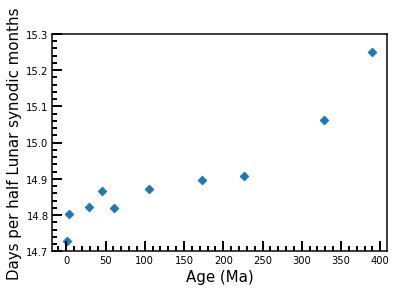

In [33]:
#Plot number of days per lunar synodic month, as in Berry & Barker (1975) Figure 2 ("Increments per Cluster")
#If we are given the number of lunar synodic months per year (from Berry & Barker's Nature, for example)
#Then we can calculate the number of days per year.
#Berry & Barker (1975) find 15 fine growth marks per half lunar period, indicating an average of 30 marks per
#synodic month, while the number of lunar days is 28.53, and the number of solar days is 29.53
#
time_Berry = []
for epoch in epoch_names_Berry:
    time_Berry.append(epoch_to_time[epoch])


fig, ax = plt.subplots()
#ax.tick_params(direction = 'in')
plt.scatter(time_Berry, days_per_half_synodic_month_Berry_average, marker='D')
#For later use
days_per_synodic_month_Berry_average = 2. * np.asarray(days_per_half_synodic_month_Berry_average)
#
plt.ylim(14.7,15.3)
plt.xlabel('Age (Ma)', fontsize = label_fontsize)
plt.ylabel('Days per half Lunar synodic months', fontsize = label_fontsize)
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=2, direction='in')
ax.tick_params(which='minor', length=5, width=2, direction='in')
plt.show()
#plt.savefig('Fig_Days_per_fortnight_Fig_2_Berry_&_Barker_1975.pdf')

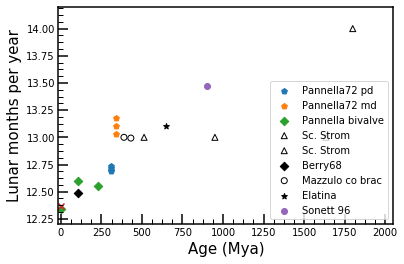

<Figure size 432x288 with 0 Axes>

In [34]:
#Lunar synodic months per year, versus age, as in Fig. 10 Williams (1989) Episodes vol. 12 162

fig, ax = plt.subplots()

#Pannella (1972) Aph. Sp.Sci. 16 212-237
plt.scatter(Pannella_Aph_Sp_Sc_1972_table_I_pennsylvanian_time, \
            Pannella_Aph_Sp_Sc_1972_table_I_pennsylvanian_months_per_year_derived, marker='p', label = 'Pannella72 pd')
plt.scatter(Pannella_Aph_Sp_Sc_1972_table_I_mississippian_time,\
           Pannella_Aph_Sp_Sc_1972_table_I_mississippian_months_per_year_derived, marker='p', label = 'Pannella72 md')
#
#Corals Scrutton Table 1
time_Scrutton_corals = []
for epoch in Scrutton_corals_epoch:
    time_Scrutton_corals.append(epoch_to_time[epoch])

#plt.scatter(time_Scrutton_corals, Scrutton_corals_synodic_months_per_year, facecolors='none',edgecolors='black')
# left out since I am using the data from Mazzullo (1971) directly, see below
#
#Bivalves Scrutton Table 2; from Pannella 72 Astrop. Sp. Sc. 

plt.scatter(time_Scrutton_bivalves, Scrutton_bivalves_synodic_months_per_year, marker="D", label = 'Pannella bivalve')
#
# #Brachiopods Scrutton Table 3---drop, since these are just Mazzullo 1971
# time_Scrutton_brachiopods = []
# for epoch in Scrutton_brachiopods_epoch:
#     time_Scrutton_brachiopods.append(epoch_to_time[epoch])

# plt.scatter(time_Scrutton_brachiopods, Scrutton_brachiopods_synodic_months_per_year, marker="D", 
#             facecolors='none', edgecolors='black', label = 'Sc brach')
#
#Stromatolites, maximum Scrutton Table 4
plt.scatter(Scrutton_stromatolites_time, Scrutton_stromatolites_synodic_months_per_year, 
           marker='^', facecolors ='none', edgecolors='black', label = 'Sc. Strom')
plt.scatter(time_Scrutton_stromatolites_pre, Scrutton_stromatolites_synodic_months_per_year_pre, 
           marker="^", facecolors='none', edgecolors='black', label = 'Sc. Strom')
#
# Berry & Barker Science (9168) (a single point from bivalves in the cretacious)
plt.scatter(Berry_68_time, Berry_68_synodic_months_per_year, marker='D', color='black', label = 'Berry68')
#
# Mazzullo (1971) Bulletin of the Geological Society of America v. 82 p1085-1086; two points from coral/brachiopods
plt.scatter(Mazzullo_corals_brachiopods_time_ave, Mazzullo_corals_brachiopods_months_per_year_ave, \
            marker='o', facecolors='none', edgecolors='black', label = 'Mazzulo co brac')
#
#Modern value, 12.37 lunar months per year
plt.scatter(0., 12.37, marker='x')
#Williams 1989 or 2000 Elatina
plt.scatter(Williams_1989_Elatina_age, Williams_1989_Elatina_lunar_months_per_year, marker = '*', color='black'\
           , label = 'Elatina')
#
# Sonett 1996  back_here
plt.scatter(Sonett_1996_age, Sonett_1996_synodic_months_per_year, label = 'Sonett 96')
#
#
plt.legend()
plt.xlim(-15., 2050.)
plt.ylim(12.2, 14.2)
plt.xlabel('Age (Mya)', fontsize = label_fontsize)
plt.ylabel('Lunar months per year', fontsize = label_fontsize)
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=1.5, direction='in')
ax.tick_params(which='minor', length=5, width=1, direction='in')
#
plt.show()
plt.savefig('Fig_synodic_months_per_year_short.pdf')

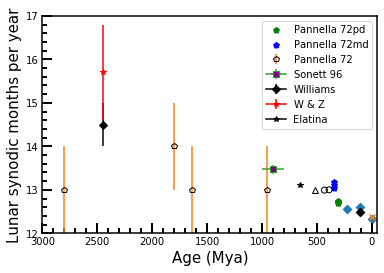

<Figure size 432x288 with 0 Axes>

In [35]:
#Lunar synodic months per year, versus age, as in Fig. 10 Williams (1989) Episodes vol. 12 162
#Data only

fig, ax = plt.subplots()

#Pannella (1972) Aph. Sp.Sci. 16 212-237
plt.scatter(Pannella_Aph_Sp_Sc_1972_table_I_pennsylvanian_time, \
            Pannella_Aph_Sp_Sc_1972_table_I_pennsylvanian_months_per_year_derived, marker='p', \
            color='green', label = 'Pannella 72pd')#Filled diamonds
plt.scatter(Pannella_Aph_Sp_Sc_1972_table_I_mississippian_time,\
           Pannella_Aph_Sp_Sc_1972_table_I_mississippian_months_per_year_derived, marker='p', \
            color='blue', label = 'Pannella 72md')#ditto
#
#Corals Scrutton Table 1
time_Scrutton_corals = []
for epoch in Scrutton_corals_epoch:
    time_Scrutton_corals.append(epoch_to_time[epoch])

#plt.scatter(time_Scrutton_corals, Scrutton_corals_synodic_months_per_year, facecolors='none',edgecolors='black')
# left out since I am using the data from Mazzullo (1971) directly, see below
#
#Bivalves Scrutton Table 2; originally from Pannella 1972 Astrop. Sp. Sc
plt.scatter(time_Scrutton_bivalves, Scrutton_bivalves_synodic_months_per_year, marker="D", Label = 'Pannella 72') #Filled diamonds
#
# #Brachiopods Scrutton Table 3; drop since these are just Mazzullo 71
# time_Scrutton_brachiopods = []
# for epoch in Scrutton_brachiopods_epoch:
#     time_Scrutton_brachiopods.append(epoch_to_time[epoch]-20)

# plt.scatter(time_Scrutton_brachiopods, Scrutton_brachiopods_synodic_months_per_year, marker="D", 
#             facecolors='none', edgecolors='black') #Hollow Diamonds
# #
#Stromatolites, maximum Scrutton Table 4
plt.errorbar(Scrutton_stromatolites_time, Scrutton_stromatolites_synodic_months_per_year, 
           marker='^', markerfacecolor ='none', markeredgecolor ='black')
            #Upward pointing black hollow triangles, redundant with Scrutton on next line, but no errors entered
plt.errorbar(time_Scrutton_stromatolites_pre, Scrutton_stromatolites_synodic_months_per_year_pre, 
           yerr = Scrutton_stromatolites_synodic_months_per_year_error_pre , \
             marker="p", markerfacecolor = 'none', ls = 'none', markeredgecolor='black', label = 'Pannella 72')
#
# Berry & Barker Science (9168) (a single point from bivalves in the cretacious)
plt.scatter(Berry_68_time, Berry_68_synodic_months_per_year, marker='D', color='black')
#
# Mazzullo (1971) Bulletin of the Geological Society of America v. 82 p1085-1086; two points from coral/brachiopods
plt.scatter(Mazzullo_corals_brachiopods_time_ave, Mazzullo_corals_brachiopods_months_per_year_ave, \
            marker='o', facecolors='none', edgecolors='black')
#
# Sonett 1996  back_here
#plt.scatter(Sonett_1996_age, Sonett_1996_synodic_months_per_year, label = 'Sonett 96')
plt.errorbar(Sonett_1996_age, Sonett_1996_synodic_months_per_year, \
             yerr = Sonett_1996_synodic_months_per_year_error, xerr = Sonett_1996_age_error,\
             label = 'Sonett 96', marker = 's', markerfacecolor = 'purple')
#
#
#
#Williams (2000) Weeli Wolli
#
plt.errorbar(Williams_1989_Weeli_Wolli_age, \
            Williams_1989_Weeli_Wolli_synodic_months_per_year, yerr = Williams_1989_Weeli_Wolli_mpy_error,\
             marker='D', color='black', label = 'Williams')
plt.errorbar(Walker_Zahnle_1986_Weeli_Wolli_age, \
            Walker_Zahnle_1986_Weeli_Wolli_synodic_months_per_year, yerr = Walker_Zahnle_1986_Weeli_Wolli_mpy_error, \
             marker='*', color='red', label = 'W & Z')
#
#Modern value, 12.37 lunar months per year
plt.scatter(0., 12.37, marker='x')
#Williams 1989 or 2000 Elatina
plt.errorbar(Williams_1989_Elatina_age, Williams_1989_Elatina_lunar_months_per_year, \
             marker = '*', color='black', label = 'Elatina')
#
plt.xlim(3000., -50)
plt.ylim(12.0, 17.)
plt.legend()
plt.xlabel('Age (Mya)', fontsize = label_fontsize)
plt.ylabel('Lunar synodic months per year', fontsize = label_fontsize)
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=2, direction='in')
ax.tick_params(which='minor', length=5, width=2, direction='in')
#
plt.show()
plt.savefig('Fig_synodic_months_per_year.pdf')
#

## Define a function to calculate the Lunar semimajor axis given the number of
## synodic months per year (the quantity measured by both tidal rhythmites and biologic tracers

In [36]:
def lunar_semimajor_axis(months_per_year):
    #Tidal Rhythmites measure the number of synodic months per year
    #Note that I add one to convert from synodic months per year to sidereal months per year to calculate
    # the semimajor axis a. Recall Keppler P=a**(3./2.), and months_per_year = Year/P_moon
    a_lunar_cgs = a_moon_cgs_0 * ( (synodic_months_per_year_present +1)/(months_per_year+1) )**(2./3.)
    return(a_lunar_cgs)


## Use this function to estimate Q for two epochs, pre- and post-Cambrian

In [37]:
#
#Find the age of the break in da/dt and the value of a at that and earlier times, by trial and error
#
break_age = 500 #Result of fiddling around is 300Mya
#
#
T_Phanerozoic = np.arange(0, 4000, 1) #Age of deposits, units are millons of years
Q_0 = Q_measured  #Current value of Q, from \dot a = 3.82 cm /yr
Q = 17  #A by-eye fit to the data gives Q=15
Q_Phanerozoic = Q  #To use in labeling plots later
#Start with the Moon at its current semimajor axis
a_1 = a_moon_cgs_0
a_T_Phanerozoic, index_when_crashed_Phanerozoic = a_of_T(T_Phanerozoic, Q, a_1)
#
# Trim T_Phanerozoic to match a_T_Phanerozic, i.e., to the times when they are both valid
#
T_Phanerozoic = T_Phanerozoic[:index_when_crashed_Phanerozoic]
#
# Find the index corresponding to 300 Mya (the break age I like)
# In the next line, I assume that this is in the Phanerozoic
#
index_of_break_age = np.asscalar(np.where(np.diff(np.signbit(T_Phanerozoic - break_age)))[0] + 1)
#
# Move on to the Precambrian
# Do this for Q = 40, 60, and 80
#
T_precambrian = np.arange(break_age, 4600, 5)  #Good for all Q_Precambrian
#Start with the Moon at the semimajor axis labeled by 'break_age', which is around 300Mya
a_1 = a_T_Phanerozoic[index_of_break_age] # ditto, since this depends on Q_Phanerozoic only 
#
# Q dependent calculations
#
Q = 40.   
Q_Precambrian_40 = Q
a_T_precambrian_40, index_precambrian_when_crashed_40 = a_of_T(T_precambrian, Q, a_1)
T_precambrian_40 = T_precambrian[:index_precambrian_when_crashed_40]
#
#Do it again with Q=50
#
Q = 50.   
Q_Precambrian_50 = Q
a_T_precambrian_50, index_precambrian_when_crashed_50 = a_of_T(T_precambrian, Q, a_1)
T_precambrian_50 = T_precambrian[:index_precambrian_when_crashed_50]
#
#
#Do it again with Q=60
#
Q = 60.   
Q_Precambrian_60 = Q
a_T_precambrian_60, index_precambrian_when_crashed_60 = a_of_T(T_precambrian, Q, a_1)
T_precambrian_60 = T_precambrian[:index_precambrian_when_crashed_60]
#
#Do it again with Q=100
#
Q = 100.   
Q_Precambrian_100 = Q
a_T_precambrian_100, index_precambrian_when_crashed_100 = a_of_T(T_precambrian, Q, a_1)
T_precambrian_100 = T_precambrian[:index_precambrian_when_crashed_100]

In a_of_T, Q=  17 11.5
In a_of_T, a_dot_1= 2584117.6470588236
In a_of_T, Q=  40.0 11.5
In a_of_T, a_dot_1= 1352977.2602851957
In a_of_T, Q=  50.0 11.5
In a_of_T, a_dot_1= 1082381.8082281565
In a_of_T, Q=  60.0 11.5
In a_of_T, a_dot_1= 901984.8401901305
In a_of_T, Q=  100.0 11.5
In a_of_T, a_dot_1= 541190.9041140783


Pannella mississippian error=  0.010582849070633293
Williams a error =  [0. 0.]


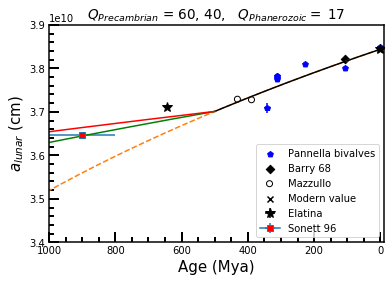

In [38]:
#Use the Lunar synodic months per year to calculate the semi-major axis of the moon versus age
#
fig, ax = plt.subplots()
#Pannella (1972) Aph. Sp.Sci. 16 212-237
plt.scatter(Pannella_Aph_Sp_Sc_1972_table_I_pennsylvanian_time, \
            lunar_semimajor_axis(Pannella_Aph_Sp_Sc_1972_table_I_pennsylvanian_months_per_year_derived), \
            marker='p', color = 'blue')#, label = 'Pannella pennd')
#
Pannella_Aph_missip_time_mean = np.mean(Pannella_Aph_Sp_Sc_1972_table_I_mississippian_time)
Pannella_Aph_missip_mean = np.mean(lunar_semimajor_axis\
                                   (Pannella_Aph_Sp_Sc_1972_table_I_mississippian_months_per_year_derived))
Pannella_Aph_missip_std  = np.std(lunar_semimajor_axis\
                                  (Pannella_Aph_Sp_Sc_1972_table_I_mississippian_months_per_year_derived))
#
print('Pannella mississippian error= ', Pannella_Aph_missip_std/1.e10)
#
plt.errorbar(Pannella_Aph_missip_time_mean,\
           Pannella_Aph_missip_mean, yerr = Pannella_Aph_missip_std,\
            marker='p', color = 'blue')#, label = 'Pannella md mean')

#
#Corals Scrutton Table 1
#time_Scrutton_corals = []
#for epoch in Scrutton_corals_epoch:
#    time_Scrutton_corals.append(epoch_to_time[epoch])

#plt.scatter(time_Scrutton_corals, Scrutton_corals_synodic_months_per_year, facecolors='none',edgecolors='black')
# left out since I am using the data from Mazzullo (1971) directly, see below
#
#Bivalves Scrutton Table 2 months per year---actually Pannella data
plt.scatter(time_Scrutton_bivalves, lunar_semimajor_axis (Scrutton_bivalves_synodic_months_per_year), \
            marker="p", color = 'blue', label = 'Pannella bivalves')
#
# #Brachiopods Scrutton Table 3 months per year; drop since these are just Mazullo 71 points
# time_Scrutton_brachiopods = []
# for epoch in Scrutton_brachiopods_epoch:
#     time_Scrutton_brachiopods.append(epoch_to_time[epoch]-20)

# plt.scatter(time_Scrutton_brachiopods, lunar_semimajor_axis \
#             (Scrutton_brachiopods_synodic_months_per_year), marker="D", 
#             facecolors='none', edgecolors='black',\
#            label = 'Scrutton brachiopods')
# #
#Stromatolites, maximum Scrutton Table 4 months per year, (II/V) divided by 2
#plt.scatter(Scrutton_stromatolites_time, lunar_semimajor_axis (Scrutton_stromatolites_synodic_months_per_year), 
#           marker='^', facecolors ='none', edgecolors='black', label = 'Stromatolites')
#plt.scatter(time_Scrutton_stromatolites_pre, lunar_semimajor_axis \
#           (Scrutton_stromatolites_synodic_months_per_year_pre), 
#           marker="^", facecolors='none', edgecolors='black', label= 'early Stromatolites')
#
# Berry & Barker Science (9168) (a single point from bivalves in the cretacious)
plt.scatter(Berry_68_time, lunar_semimajor_axis (Berry_68_synodic_months_per_year), \
            marker='D', color='black', label = 'Barry 68')
#
# Mazzullo (1971) Bulletin of the Geological Society of America v. 82 p1085-1086; 
#two points from coral/brachiopods
plt.scatter(Mazzullo_corals_brachiopods_time_ave, \
            lunar_semimajor_axis(Mazzullo_corals_brachiopods_months_per_year_ave), \
            marker='o', facecolors='none', edgecolors='black', label='Mazzullo')
#
# Weeli Wolli (Banded Iron) point
#plt.scatter(Williams_1989_Weeli_Wolli_age, \
#            lunar_semimajor_axis(Williams_1989_Weeli_Wolli_synodic_months_per_year), \
#                label='Weeli Wolli Williams')
#plt.scatter(Walker_Zahnle_1986_Weeli_Wolli_age, \
#            lunar_semimajor_axis(Walker_Zahnle_1986_Weeli_Wolli_synodic_months_per_year), \
#            label='Weeli Wolli W&Z')
#
#Modern value, 12.37 lunar (synodic) months per year
plt.scatter(0., lunar_semimajor_axis(12.37), marker='x', color = 'black', label = 'Modern value')
#Williams 1989 or 2000 Elatina
# plt.scatter(Williams_1989_Elatina_age, \
#             lunar_semimajor_axis(Williams_1989_Elatina_lunar_months_per_year), \
#             marker = '*', s = 80, color='black', label='Elatina')
#
Williams_2000_Elatina_semimajor_axis_p = \
lunar_semimajor_axis(Williams_2000_Elatina_lunar_months_per_year+Williams_2000_Elatina_lunar_months_per_year_error)
Williams_2000_Elatina_semimajor_axis_m = \
lunar_semimajor_axis(Williams_2000_Elatina_lunar_months_per_year-Williams_2000_Elatina_lunar_months_per_year_error)
Williams_2000_Elatina_semimajor_axis_error = \
Williams_2000_Elatina_semimajor_axis_m - Williams_2000_Elatina_semimajor_axis_m
print('Williams a error = ', Williams_2000_Elatina_semimajor_axis_error)
#
plt.errorbar(Williams_2000_Elatina_age, \
            lunar_semimajor_axis(Williams_2000_Elatina_lunar_months_per_year), \
            yerr = Williams_2000_Elatina_semimajor_axis_error, \
             xerr = Williams_2000_Elatina_age_error, marker = '*', \
             ls = 'none', markersize = 10, color='black', label='Elatina')
#
# Sonett 1996
# plt.scatter(Sonett_1996_age, \
#             lunar_semimajor_axis(Sonett_1996_synodic_months_per_year), label = 'Sonett 96')
plt.errorbar(Sonett_1996_age, lunar_semimajor_axis(Sonett_1996_synodic_months_per_year), \
             yerr = Sonett_1996_synodic_months_per_year_error, xerr = Sonett_1996_age_error,\
             label = 'Sonett 96', marker = 's', markerfacecolor = 'red')
#
#
#
#
#Plot the theory, first for the low Q Phanerozic
#
plt.plot(T_Phanerozoic, a_T_Phanerozoic, ls='--')# a_of_T returns a shortend vector a_T when Moon hits Earth
plt.plot(T_Phanerozoic[:index_of_break_age], a_T_Phanerozoic[:index_of_break_age], ls = '-', color = 'black')
#
#The two Precambrain lines
#
plt.plot(T_precambrian_40, a_T_precambrian_40, c = 'green')
plt.plot(T_precambrian_60, a_T_precambrian_60, c ='red')
#
#
plt.xlabel('Age (Mya)', fontsize = label_fontsize)
plt.ylabel('$a_{lunar}$ (cm)', fontsize = label_fontsize)
plt.legend()
plt.xlim(1000.,-10)
plt.ylim(3.4e10, 3.9e10)
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=2, direction='in')
ax.tick_params(which='minor', length=5, width=2, direction='in')
plt.title('$Q_{Precambrian}$ = %i, %i,   $Q_{Phanerozoic}=$ %i'%(Q_Precambrian_60, Q_Precambrian_40, Q_Phanerozoic), \
          fontsize = label_fontsize * .9)
#
filename = 'Fig_Lunar_semimajor_axis_vs_age_Q_' + str(int(Q_Precambrian_60)) + '_recent.pdf'
plt.savefig(filename)
plt.savefig('Fig_a_vs_age_short.png')
plt.show()
#

In [39]:
a_T_Phanerozoic[index_of_break_age]/1.e10

3.700944733771979

Willams_Elatina_error = [1.75427383e+08]


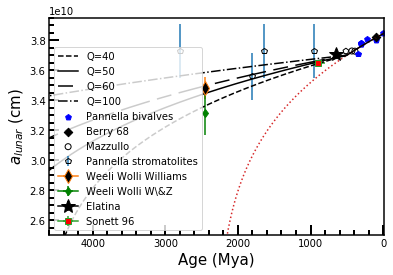

In [40]:
# Now plot the full history of the Earth
#
fig, ax = plt.subplots()
#
# Full time
# Data first, then theory
# Pannella (1972) Aph. Sp.Sci. 16 212-237
plt.scatter(Pannella_Aph_Sp_Sc_1972_table_I_pennsylvanian_time, \
            lunar_semimajor_axis (Pannella_Aph_Sp_Sc_1972_table_I_pennsylvanian_months_per_year_derived), \
            marker='p', color = 'blue')#, label = 'Pannella 72 pd')
#plt.scatter(Pannella_Aph_Sp_Sc_1972_table_I_mississippian_time,\
#           lunar_semimajor_axis (Pannella_Aph_Sp_Sc_1972_table_I_mississippian_months_per_year_derived), marker='p')
Pannella_Aph_missip_time_mean = np.mean(Pannella_Aph_Sp_Sc_1972_table_I_mississippian_time)
Pannella_Aph_missip_mean = np.mean(lunar_semimajor_axis(Pannella_Aph_Sp_Sc_1972_table_I_mississippian_months_per_year_derived))
Pannella_Aph_missip_std  = np.std(lunar_semimajor_axis(Pannella_Aph_Sp_Sc_1972_table_I_mississippian_months_per_year_derived))
#
plt.errorbar(Pannella_Aph_missip_time_mean,\
           Pannella_Aph_missip_mean, yerr = Pannella_Aph_missip_std,\
            marker='p', color = 'blue')#, label = 'Pannella bivalves md')


#
#Bivalves Scrutton Table 2 months per year; from Pannella 72   
plt.scatter(time_Scrutton_bivalves, lunar_semimajor_axis (Scrutton_bivalves_synodic_months_per_year), \
            marker="p", color = 'blue', label = 'Pannella bivalves')
#
# #Brachiopods Scrutton Table 3 months per year; drop since these are Mazzullo 71 points
# time_Scrutton_brachiopods = []
# for epoch in Scrutton_brachiopods_epoch:
#     time_Scrutton_brachiopods.append(epoch_to_time[epoch]-20)

# plt.scatter(time_Scrutton_brachiopods, lunar_semimajor_axis (Scrutton_brachiopods_synodic_months_per_year), marker="D", 
#             facecolors='none', edgecolors='black', label = 'Scrutton brachiopods')

#Stromatolites, maximum Scrutton Table 4 months per year, (II/V) divided by 2. From Panella 72
plt.scatter(Scrutton_stromatolites_time, lunar_semimajor_axis (Scrutton_stromatolites_synodic_months_per_year), 
           marker='p', facecolors ='none', edgecolors='black')
#
#Put error bars on the precambrian data
#
stromat_semi_error_pre_plus = lunar_semimajor_axis (Scrutton_stromatolites_synodic_months_per_year_pre + 1)
stromat_semi_error_pre_minus = lunar_semimajor_axis (Scrutton_stromatolites_synodic_months_per_year_pre - 1)
stromat_semi = lunar_semimajor_axis (Scrutton_stromatolites_synodic_months_per_year_pre)
stromat_semi_error = (stromat_semi_error_pre_minus - stromat_semi_error_pre_plus )/2.
#print('Stromatolite errors', stromat_semi_error_pre_plus, stromat_semi_error_pre_minus, stromat_semi)
#
plt.errorbar(time_Scrutton_stromatolites_pre, \
             lunar_semimajor_axis (Scrutton_stromatolites_synodic_months_per_year_pre), 
            yerr = stromat_semi_error , marker="p", markerfacecolor = 'none', markeredgecolor = 'black', \
             ls = 'none' , label = 'Pannella stromatolites')
#print('Scrutton stromatolite data', time_Scrutton_stromatolites_pre, \
#     Scrutton_stromatolites_synodic_months_per_year_pre)
#
# Berry & Barker Science (9168) (a single point from bivalves in the cretacious)
plt.scatter(Berry_68_time, lunar_semimajor_axis (Berry_68_synodic_months_per_year), marker='D', color='black',\
           label = 'Berry 68')
#
# Mazzullo (1971) Bulletin of the Geological Society of America v. 82 p1085-1086; two points from coral/brachiopods
plt.scatter(Mazzullo_corals_brachiopods_time_ave, \
            lunar_semimajor_axis(Mazzullo_corals_brachiopods_months_per_year_ave), \
            marker='o', facecolors='none', edgecolors='black', label='Mazzullo')
#
# Weeli Wolli (Banded Iron) point
#
Weeli_Wolli_semimajoraxis = lunar_semimajor_axis(Williams_1989_Weeli_Wolli_synodic_months_per_year)
Weeli_Wolli_semi_plus = \
lunar_semimajor_axis(Williams_1989_Weeli_Wolli_synodic_months_per_year + Williams_1989_Weeli_Wolli_mpy_error)
Weeli_Wolli_semi_minus = \
lunar_semimajor_axis(Williams_1989_Weeli_Wolli_synodic_months_per_year - Williams_1989_Weeli_Wolli_mpy_error)
Weeli_Wolli_Williams_semi_a_err = (Weeli_Wolli_semi_plus - Weeli_Wolli_semi_minus)/2.
#
#print('Weeli Wolli a = ', Weeli_Wolli_semimajoraxis)
plt.errorbar(Williams_1989_Weeli_Wolli_age, \
#plt.scatter(Williams_1989_Weeli_Wolli_age, \
            Weeli_Wolli_semimajoraxis, yerr = Weeli_Wolli_Williams_semi_a_err , \
             xerr = Williams_1989_Weeli_Wolli_age_error, \
             marker = 'd', markersize = 10, markerfacecolor = 'black', label='Weeli Wolli Williams')
#
#
Weeli_Wolli_semimajoraxis = lunar_semimajor_axis(Walker_Zahnle_1986_Weeli_Wolli_synodic_months_per_year)
Weeli_Wolli_Walker_semi_plus = \
lunar_semimajor_axis(Walker_Zahnle_1986_Weeli_Wolli_synodic_months_per_year + Walker_Zahnle_1986_Weeli_Wolli_mpy_error)
Weeli_Wolli_Walker_semi_minus = \
lunar_semimajor_axis(Walker_Zahnle_1986_Weeli_Wolli_synodic_months_per_year - Walker_Zahnle_1986_Weeli_Wolli_mpy_error)
Weeli_Wolli_Walker_semi_a_err = (Weeli_Wolli_Walker_semi_plus - Weeli_Wolli_Walker_semi_minus)/2.
#
plt.errorbar(Walker_Zahnle_1986_Weeli_Wolli_age, \
            lunar_semimajor_axis(Walker_Zahnle_1986_Weeli_Wolli_synodic_months_per_year), \
            yerr = Weeli_Wolli_Walker_semi_a_err , xerr = Williams_1989_Weeli_Wolli_age_error,\
             marker = 'd', color = 'green', label = 'Weeli Wolli W\&Z')
#
#
#Modern value, 12.37 lunar months per year
plt.scatter(0., 12.37, marker='x')
#Williams 1989 or 2000 Elatina
#Work out the error bar on the semimajor axis
#
Williams_Elatina_a = lunar_semimajor_axis(Williams_1989_Elatina_lunar_months_per_year)
Williams_Elatina_a_plus = lunar_semimajor_axis(Williams_1989_Elatina_lunar_months_per_year + \
                                               Williams_1989_Elatina_lunar_months_per_year_error)
Williams_Elatina_a_minus = lunar_semimajor_axis(Williams_1989_Elatina_lunar_months_per_year - \
                                               Williams_1989_Elatina_lunar_months_per_year_error)
Williams_Elatina_a_err = (Williams_Elatina_a_minus - Williams_Elatina_a_plus)/2.
print('Willams_Elatina_error =', Williams_Elatina_a_err)
plt.errorbar(Williams_1989_Elatina_age, \
            Williams_Elatina_a , \
            yerr = Williams_Elatina_a_err , marker = '*', \
             markersize = 15, color='black', label='Elatina')
#
# Sonett 1996
# plt.scatter(Sonett_1996_age, \
#             lunar_semimajor_axis(Sonett_1996_synodic_months_per_year), label = 'Sonett 96')
#
plt.errorbar(Sonett_1996_age, lunar_semimajor_axis(Sonett_1996_synodic_months_per_year), \
             yerr = Sonett_1996_synodic_months_per_year_error, xerr = Sonett_1996_age_error,\
             label = 'Sonett 96', marker = 's', markerfacecolor = 'red')
#
#
#
#Now the theory
#
#
plt.plot(T_Phanerozoic, a_T_Phanerozoic, ls=':')
plt.plot(T_Phanerozoic[:index_of_break_age], a_T_Phanerozoic[:index_of_break_age], ls = '-', color = 'black')
#
plt.plot(T_precambrian_40, a_T_precambrian_40, color = 'black', ls ='--', label = 'Q=40')
plt.plot(T_precambrian_50, a_T_precambrian_50, color = 'black',  label = 'Q=50')
plt.plot(T_precambrian_60, a_T_precambrian_60, color = 'black', dashes=[10, 5, 20, 5], label = 'Q=60')
plt.plot(T_precambrian_100, a_T_precambrian_100, color = 'black', ls = '-.', label = 'Q=100')
#
#
plt.xlim(4600.,-10)
plt.ylim(2.5e10, 3.95e10)
#
plt.xlabel('Age (Mya)', fontsize = label_fontsize)
plt.ylabel('$a_{lunar}$ (cm)', fontsize = label_fontsize)
plt.legend(loc = 3) #3 = lower left
#plt.title('$Q_{Precambrian}$ = %i, %i,   $Q_{Phanerozoic}=$ %i'\
#          %(Q_Precambrian_60, Q_Precambrian_40, Q_Phanerozoic), \
#          fontsize = label_fontsize *0.9)
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=2, direction='in')
ax.tick_params(which='minor', length=5, width=2, direction='in')
#
filename = 'Fig_Lunar_semimajor_axis_vs_age_three_Q.pdf'
plt.savefig(filename)
plt.show()

In [41]:
Scrutton_stromatolites_synodic_months_per_year

array([13])

In [42]:
print(Pannella_Aph_Sp_Sc_1972_table_I_mississippian_months_per_year_derived, Scrutton_bivalves_synodic_months_per_year)
print('Scruttons version of Pannella stromatolites', Scrutton_stromatolites_synodic_months_per_year_pre)

[13.18136769 13.03348654 13.10503787] [12.34 12.6  12.55]
Scruttons version of Pannella stromatolites [13. 14. 13. 13.  1.  1.]


Total_Q_40 =  [17. 17. 17. ... 40. 40. 40.]
lengths 40 820 820
lengths 50 820 820
lengths 60 820 820


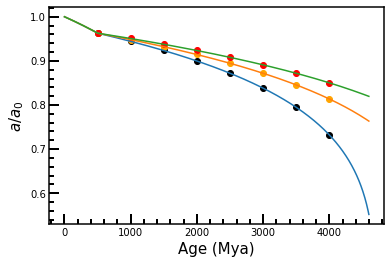

In [43]:
#### Use the analytic result to map age into lunar semimajor axis
#print('a_T_precambrian =', a_T_precambrian)
Total_T_40 = np.concatenate((T_Phanerozoic[:np.int(index_of_break_age)], T_precambrian_40))
Total_a_40 = np.concatenate((a_T_Phanerozoic[:np.int(index_of_break_age)], a_T_precambrian_40))
Total_Q_40 = np.zeros(Total_a_40.size)
Total_Q_40[:np.int(index_of_break_age)] = Q_Phanerozoic
Total_Q_40[np.int(index_of_break_age):] = 40.
print('Total_Q_40 = ', Total_Q_40)
#
Total_T_50 = np.concatenate((T_Phanerozoic[:np.int(index_of_break_age)], T_precambrian_50))
Total_a_50 = np.concatenate((a_T_Phanerozoic[:np.int(index_of_break_age)], a_T_precambrian_50))
Total_Q_50 = np.zeros(Total_a_50.size)
Total_Q_50[:np.int(index_of_break_age)] = Q_Phanerozoic
Total_Q_50[np.int(index_of_break_age):] = 50.

Total_T_60 = np.concatenate((T_Phanerozoic[:np.int(index_of_break_age)], T_precambrian_60))
Total_a_60 = np.concatenate((a_T_Phanerozoic[:np.int(index_of_break_age)], a_T_precambrian_60))
Total_Q_60 = np.zeros(Total_a_60.size)
Total_Q_60[:np.int(index_of_break_age)] = Q_Phanerozoic
Total_Q_60[np.int(index_of_break_age):] = 60.


Total_T_100 = np.concatenate((T_Phanerozoic[:np.int(index_of_break_age)], T_precambrian_100))
Total_a_100 = np.concatenate((a_T_Phanerozoic[:np.int(index_of_break_age)], a_T_precambrian_100))
Total_Q_100 = np.zeros(Total_a_100.size)
Total_Q_100[:np.int(index_of_break_age)] = Q_Phanerozoic
Total_Q_100[np.int(index_of_break_age):] = 100.
#
print('lengths 40', len(T_precambrian_40), len(a_T_precambrian_40))
print('lengths 50', len(T_precambrian_50), len(a_T_precambrian_50))
print('lengths 60', len(T_precambrian_60), len(a_T_precambrian_60))
#print('a_T_precambrian', a_T_precambrian)
def given_age_find_lunar_semimajor_axis(age, Total_T, Total_a):
    #age is assumed to be in millions of year
    #Find the index corresponding to the age passed in to the routine
    magic_index = np.where(np.diff(np.signbit(Total_T - age)))[0] 
    semimajor_axis = Total_a[magic_index]
    #print(magic_index, Total_T[magic_index], age, semimajor_axis)
    return(semimajor_axis)
    
def given_semimajor_axis_find_age(semimajor_axis, Total_T, Total_a):
    #semimajor axis is assumed to be a/a_0. I need to check that semimajor axis is in the
    #range of Total_a, but I have not implimented it yet 
    #Find the index corresponding to the semimajor axis passed in to the routine
    magic_index = np.where(np.diff(np.signbit(Total_a - semimajor_axis)))[0]
    age = Total_T[magic_index]
    return(age)

fig, ax = plt.subplots()
#given_age_find_lunar_semimajor_axis(500., Total_T, Total_a)
plt.plot(Total_T_40, Total_a_40/a_moon_cgs_0)
plt.plot(Total_T_50, Total_a_50/a_moon_cgs_0)
plt.plot(Total_T_60, Total_a_60/a_moon_cgs_0)
#print("Total_T = ", Total_T)
test_time = range(500,4500,500)
for time in test_time:
    plt.scatter(time, given_age_find_lunar_semimajor_axis(time, Total_T_40, Total_a_40)/a_moon_cgs_0, color='black')
    plt.scatter(time, given_age_find_lunar_semimajor_axis(time, Total_T_50, Total_a_50)/a_moon_cgs_0, color='orange')
    plt.scatter(time, given_age_find_lunar_semimajor_axis(time, Total_T_60, Total_a_60)/a_moon_cgs_0, color='red')

plt.xlabel('Age (Mya)', fontsize = label_fontsize)
plt.ylabel('$a/a_0$', fontsize = label_fontsize)
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=2, direction='in')
ax.tick_params(which='minor', length=5, width=2, direction='in')
#
plt.show()
#plt.savefig('Fig_semimajor_axis_vs_age.pdf')

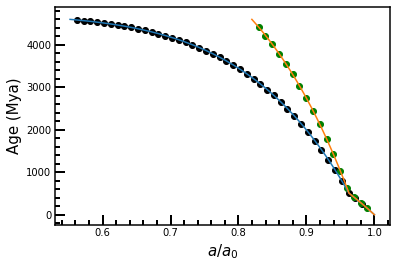

In [44]:
#Plot the age corresponding to a give semimajor axis
fig, ax = plt.subplots()
plt.plot(Total_a_40/a_moon_cgs_0, Total_T_40)
plt.plot(Total_a_60/a_moon_cgs_0, Total_T_60)
#print("Total_a/a_0, Total_T=", Total_a/a_moon_cgs_0, Total_T)
test_semimajor_axis = np.arange(Total_a_40[-1]/a_moon_cgs_0+0.01, 0.99, .01)
#print('test_semimajor_axis =', test_semimajor_axis)

#
for semimajor_axis in test_semimajor_axis:
    result = given_semimajor_axis_find_age(semimajor_axis, Total_T_40, Total_a_40/a_moon_cgs_0)
    #print('a, result = ', semimajor_axis, result)
    plt.scatter(semimajor_axis, result, color = 'black')
    
test_semimajor_axis = np.arange(Total_a_60[-1]/a_moon_cgs_0+0.01, 0.99, .01)
for semimajor_axis in test_semimajor_axis:
    result = given_semimajor_axis_find_age(semimajor_axis, Total_T_60, Total_a_60/a_moon_cgs_0)
    #print('a, result = ', semimajor_axis, result)
    plt.scatter(semimajor_axis, result, color = 'green')
    

plt.xlabel('$a/a_0$', fontsize = label_fontsize)
plt.ylabel('Age (Mya)', fontsize = label_fontsize)
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=2, direction='in')
ax.tick_params(which='minor', length=5, width=2, direction='in')
#
plt.show()
#plt.savefig('Fig_age_versus_semimajor_axis.pdf')

## Calculate the number days per month assuming only gravitational tides, and for fixed day length

Following Runcorn (1979) *Physics of the Earth and Planetary Interiors*, **20** pp1-5, assume that
there are only gravitational tidal torques operating to predict the number of lunar days per synodic month ($s'$)
as a function of $x\equiv r/r_0$. Plot the resulting curve along with data from tidal rhythmites (Eriksson & Simpson (2000), Bhattacharaya (2015), Mazumder (2004), Williams (1989) or (2000)) and possibly from stromatolites (Pannell (1972) and Mohr (1975)).

In [45]:
# set various ratios (days/month, Months/year,...) at the present time
solar_days_per_month = 27.3 #solar days per synodic month, if large bands are tidal, and small bands are due to light variations
sidereal_months_per_year = 13.37
lunar_to_Earth_angular_momentum = 4.83 #From values in Yoder (1995) Global Earth Physics; Runcorn uses 4.82

In [46]:
# x = r/r_0 where r is the Lunar semimajor axis and _0 means the present time
x_theory = np.arange(0.67,1.005,0.01)
age_tides_day_40 = []

print(Total_T_40)
for semi_major in x_theory:
    test_age = given_semimajor_axis_find_age(semi_major, Total_T_40, Total_a_40/a_moon_cgs_0)
    if(test_age.size > 0):
        age_tides_day_40.append(np.asscalar(test_age))
        #print('test_age = ', test_age)

print('age_tides_day_40 = ', age_tides_day_40)
x_theory_40 = x_theory[:len(age_tides_day_40)]
print('lengths 40 =', Total_T_40.size, len(age_tides_day_40), x_theory_40.size)
#
#
age_tides_day_60 = []
print(Total_T_60)
for semi_major in x_theory:
    test_age = given_semimajor_axis_find_age(semi_major, Total_T_60, Total_a_60/a_moon_cgs_0)
    if(test_age.size > 0):
        age_tides_day_60.append(np.asscalar(test_age))
        #print('test_age = ', test_age)

print('age_tides_day_60 = ', age_tides_day_60)
x_theory_60 = x_theory[:len(age_tides_day_60)]
print('lengths 60 =', Total_T_60.size, len(age_tides_day_60), x_theory_60.size)
#
x_one_half = np.sqrt(x_theory)
x_three_halves = x_theory*x_one_half
x_thirteen_halves = x_theory**(13./2.)
index_where_x_const_plotted = np.where(x_theory>0.6)

[   0    1    2 ... 4585 4590 4595]
age_tides_day_40 =  [4305, 4265, 4225, 4175, 4125, 4070, 4010, 3945, 3875, 3800, 3720, 3635, 3540, 3445, 3335, 3225, 3100, 2970, 2835, 2685, 2530, 2360, 2180, 1990, 1790, 1575, 1345, 1105, 850, 575, 411, 281, 144]
lengths 40 = 1320 33 33
[   0    1    2 ... 4585 4590 4595]
age_tides_day_60 =  [4585, 4405, 4210, 4000, 3780, 3545, 3290, 3025, 2740, 2435, 2110, 1770, 1410, 1025, 615, 411, 281, 144]
lengths 60 = 1320 18 18


In [47]:
#beta is the ratio of the solar to lunar tidal torque, with a best estimate of 4.7, 
#Runcorn uses two bracketing values
#This expression is for solar days, i.e., biological data assuming sunlight drives the growth
#When plotting tidal rhythmite data lunar days should be used
beta_47 = 1./4.7
beta_5 = 1./5.1
beta_3 = 1./3.4
numerator_5 = 1. + lunar_to_Earth_angular_momentum * ( (1.-x_one_half) + beta_5/13. * (1.- x_thirteen_halves) )
numerator_47 = 1. + lunar_to_Earth_angular_momentum * ( (1.-x_one_half) + beta_47/13. * (1.- x_thirteen_halves) )
numerator_3 = 1. + lunar_to_Earth_angular_momentum * ( (1.-x_one_half) + beta_3/13. * (1.- x_thirteen_halves) )
s_solar_days_5 = solar_days_per_month * x_theory**1.5 * numerator_5 / (1.- x_three_halves /sidereal_months_per_year )
s_solar_days_47 = solar_days_per_month * x_theory**1.5 * numerator_5 / (1.- x_three_halves /sidereal_months_per_year )
s_solar_days_3 = solar_days_per_month * x_theory**1.5 * numerator_3 / (1.- x_three_halves /sidereal_months_per_year)

In [48]:
#constant beta version
numerator_5c = 1. + lunar_to_Earth_angular_momentum * (1.+beta_5) *(1-x_one_half) 
numerator_3c = 1. + lunar_to_Earth_angular_momentum * (1.+beta_3) *(1-x_one_half)
s_constant_beta_5 = solar_days_per_month * x_theory**1.5 * numerator_5c / (1.- x_three_halves/sidereal_months_per_year)
s_constant_beta_3 = solar_days_per_month * x_theory**1.5 * numerator_3c / (1.- x_three_halves/sidereal_months_per_year)

## Now the constant daylength prediction

In [49]:
#Constant daylength for r/r_break
#Find the ratio a/a_0 at the time when the l.o.d. ceased to be constant (called break_age above)
#First find the semimajor axis at the time when
#the resonance breaks (hence 'break_age'), which I chose by hand
#
T_1_over_t_1 = 28.3  #Solar days per sidereal month, Williams Table 1 column 5 row 3, should be given at the break age
#
#
x_const_day_start_40 = given_age_find_lunar_semimajor_axis(break_age, Total_T_40, Total_a_40)/a_moon_cgs_0
#Now find the minimum semimajor axis, which depends on Q. 
x_const_day_min_40 = given_age_find_lunar_semimajor_axis(Total_T_40[-1], Total_T_40, Total_a_40)/a_moon_cgs_0
#print("Total_T", Total_T[-1], x_const_day_min)
x_const_day_40 = np.arange(x_const_day_min_40, x_const_day_start_40, 0.01)
#
# Find the age corresponding to this x, for the same Q
#
age_const_day_40 = []

for semi_major in x_const_day_40:
    age_const_day_40.append(np.asscalar\
                            (given_semimajor_axis_find_age(semi_major, Total_T_40, Total_a_40/a_moon_cgs_0)))


#
x_const_day_three_halves_40 = x_const_day_40**1.5

#Version from my notes on p47 of Sept. 2018 Notebook, from 14 October 2018
#Use x_const_day from cell above
#print(T_1_over_t_1)
x_three_halves_scaled_40 = x_const_day_three_halves_40/x_const_day_three_halves_40[-1] # a/a_1 in the notes
#print(x_use)
s_October_14_40 = T_1_over_t_1 * x_three_halves_scaled_40 / \
(1. - x_three_halves_scaled_40/Williams_2000_Elatina_sidereal_months_per_year[1])
#
s_prime_October_14_40 = (T_1_over_t_1 * x_three_halves_scaled_40 - 1.)/\
(1. - x_three_halves_scaled_40/Williams_2000_Elatina_sidereal_months_per_year[1])

In [50]:
# Same thing for Q=60
#
x_const_day_start_60 = given_age_find_lunar_semimajor_axis(break_age, Total_T_60, Total_a_60)/a_moon_cgs_0
#Now find the minimum semimajor axis, which depends on Q. 
x_const_day_min_60 = given_age_find_lunar_semimajor_axis(Total_T_60[-1], Total_T_60, Total_a_60)/a_moon_cgs_0
#print("Total_T", Total_T[-1], x_const_day_min)
x_const_day_60 = np.arange(x_const_day_min_60, x_const_day_start_60, 0.01)
#
# Find the age corresponding to this x, for the same Q
#
age_const_day_60 = []

for semi_major in x_const_day_60:
    age_const_day_60.append(np.asscalar\
                            (given_semimajor_axis_find_age\
                             (semi_major, Total_T_60, Total_a_60/a_moon_cgs_0)))

#
x_const_day_three_halves_60 = x_const_day_60**1.5

#Version from my notes on p47 of Sept. 2018 Notebook, from 14 October 2018
#Use x_const_day from cell above
#
x_three_halves_scaled_60 = x_const_day_three_halves_60/x_const_day_three_halves_60[-1] # a/a_1 in the notes
#
s_October_14_60 = T_1_over_t_1 * x_three_halves_scaled_60 / \
(1. - x_three_halves_scaled_60/Williams_2000_Elatina_sidereal_months_per_year[1])
#
s_prime_October_14_60 = (T_1_over_t_1 * x_three_halves_scaled_60 - 1.)/\
(1. - x_three_halves_scaled_60/Williams_2000_Elatina_sidereal_months_per_year[1])
#

#

In [51]:
# 
# And for Q=100
#
x_const_day_start_100 = given_age_find_lunar_semimajor_axis(break_age, Total_T_100, Total_a_100)/a_moon_cgs_0
#Now find the minimum semimajor axis, which depends on Q. 
x_const_day_min_100 = given_age_find_lunar_semimajor_axis(Total_T_100[-1], Total_T_100, Total_a_100)/a_moon_cgs_0
#print("Total_T", Total_T[-1], x_const_day_min)
x_const_day_100 = np.arange(x_const_day_min_100, x_const_day_start_100, 0.01)
#
# Find the age corresponding to this x, for the same Q
#
age_const_day_100 = []

for semi_major in x_const_day_100:
    age_const_day_100.append(np.asscalar\
                            (given_semimajor_axis_find_age\
                             (semi_major, Total_T_100, Total_a_100/a_moon_cgs_0)))

#
x_const_day_three_halves_100 = x_const_day_100**1.5

#Version from my notes on p47 of Sept. 2018 Notebook, from 14 October 2018
#Use x_const_day from cell above
#
x_three_halves_scaled_100 = x_const_day_three_halves_100/x_const_day_three_halves_100[-1] # a/a_1 in the notes
#
s_October_14_100 = T_1_over_t_1 * x_three_halves_scaled_100 / \
(1. - x_three_halves_scaled_100/Williams_2000_Elatina_sidereal_months_per_year[1])
#
s_prime_October_14_100 = (T_1_over_t_1 * x_three_halves_scaled_100 - 1.)/\
(1. - x_three_halves_scaled_100/Williams_2000_Elatina_sidereal_months_per_year[1])

Plot the number of either solar or lunar days per synodic month versus $x\equiv r/r_0$, as in Runcorn
The concept of number of days is ambiguous, since tidal rhythmites record lunar days, while
biological indicators could track either lunar days or solar days, e.g., corals could respond to daylight.

Eriksson age error a =  [0.83232451]


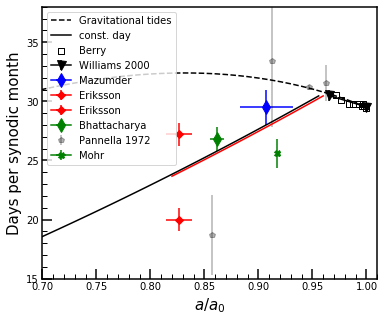

In [52]:
plt.rc('text', usetex=False)
fig, ax = plt.subplots(figsize=(6,5)) #Default is 6 wide, 4 high, i.e., figsize = (6,4)
#lt.plot(x_theory,s_solar_days_5)
plt.plot(x_theory, s_solar_days_47, ls = '--', c = 'black', label = 'Gravitational tides')
#
plt.plot(x_const_day_60, s_October_14_60,  c = 'red')
plt.plot(x_const_day_40, s_October_14_40, label = 'const. day', c = 'black')
#plt.plot(x_const_day, s_prime_October_14, ls='--', label = "s'")
#
#Plot the data
#
#Cambrian and later
#
Total_T = Total_T_40
Total_a = Total_a_40
#
a_Berry = []
for time in time_Berry:
    a_Berry.append(given_age_find_lunar_semimajor_axis(time, Total_T, Total_a_40))

a_Berry = np.asarray(a_Berry)

plt.scatter(a_Berry/a_moon_cgs_0, days_per_synodic_month_Berry_average, marker='s', facecolors='none', \
           edgecolors = 'black', label = 'Berry')
#plt.scatter(x_williams, s_prime_lunar_days_per_synodic_month_williams, marker='v') #downward triangle
#Williams measures the lunar semimajor axis with the 600Mya Elatina data, so we don't need to use our fit
plt.errorbar(x_williams, \
            s_solar_days_per_synodic_month_williams, \
            yerr = s_solar_days_per_synodic_month_williams_error,\
             markersize = 9, marker='v', c = 'black', label='Williams 2000')
#
# Scrutton bivalves---don't need since they are just Berry 
#
a_Scrutton_bivalves = []
for time in time_Scrutton_bivalves_days_per_month:
    a_Scrutton_bivalves.append(given_age_find_lunar_semimajor_axis(time, Total_T, Total_a))
    
a_Scrutton_bivalves = np.asarray(a_Scrutton_bivalves)/a_moon_cgs_0
#
#plt.errorbar(a_Scrutton_bivalves, Scrutton_bivalves_days_per_month, \
#             marker = 'D', c = 'red', ls = 'none' , label = 'Bivalves')
#
#Precambrian
#
#plot tidal rhythmites from Eriksson, from Bhattacharaya, and from Mazumder
#Convert tidaly rhythmite days, which are lunar days per month, to solar days per month, i.e., add 1
#
#Calculate the error in the semimajor axis calculated from the age of the sample
#
Mazumder_a_error = given_age_find_lunar_semimajor_axis\
(Mazumder_age - Mazumder_age_error, Total_T, Total_a)/a_moon_cgs_0\
-given_age_find_lunar_semimajor_axis\
(Mazumder_age + Mazumder_age_error, Total_T, Total_a)/a_moon_cgs_0 
#
plt.errorbar(given_age_find_lunar_semimajor_axis(Mazumder_age, Total_T, \
                                                 Total_a)/a_moon_cgs_0, Mazumder_days_per_month+1, \
             yerr = Mazumder_days_per_month_error, xerr = Mazumder_a_error, \
             marker='d', markersize = 10, c='blue', label='Mazumder') #blue pentagon

Eriksson_age_error_a = given_age_find_lunar_semimajor_axis\
(Eriksson_age[0] - Eriksson_age_error[0], Total_T, Total_a)/a_moon_cgs_0
print('Eriksson age error a = ', Eriksson_age_error_a)
#
Eriksson_age_error_b = given_age_find_lunar_semimajor_axis\
(Eriksson_age[0] + Eriksson_age_error[0], Total_T, Total_a)/a_moon_cgs_0 
#
Eriksson_a_error = Eriksson_age_error_a - Eriksson_age_error_b
#
plt.errorbar(given_age_find_lunar_semimajor_axis(Eriksson_age[0], Total_T, Total_a)/a_moon_cgs_0, \
            Eriksson_days_per_month[0]+1, yerr = Eriksson_days_per_month_error[0],\
             xerr = Eriksson_a_error, marker='D', c='red', label='Eriksson') #red diamond
plt.errorbar(given_age_find_lunar_semimajor_axis(Eriksson_age[0], Total_T, Total_a)/a_moon_cgs_0, \
            Eriksson_days_per_month[1]+1, yerr = Eriksson_days_per_month_error[0],\
             xerr = Eriksson_a_error, marker='D', c='red', label='Eriksson') #red diamond
#
#
# Calculate the error in semimajor axis from the error in the age estimate
Bh_minus = Bhattacharya_age - Bhattacharya_age_error
Bh_plus = Bhattacharya_age + Bhattacharya_age_error
Bh_a_error_a = given_age_find_lunar_semimajor_axis(Bh_minus, Total_T, Total_a)/a_moon_cgs_0
Bh_a_error_b = given_age_find_lunar_semimajor_axis(Bh_plus, Total_T, Total_a)/a_moon_cgs_0 
Bh_a_error = Bh_a_error_a - Bh_a_error_b
#
plt.errorbar(given_age_find_lunar_semimajor_axis\
             (Bhattacharya_age, Total_T, Total_a)/a_moon_cgs_0, \
             Bhattacharya_days_per_month+1, \
             yerr = Bhattacharya_days_per_month_error, \
             xerr = Bh_a_error, marker = 'd', markersize ='10', c='green', label='Bhattacharya')
#
#
# Stromatolites
# Scrutton argues that the daily growth patterns follow the solar (rather than lunar) day, as modern 
# mats of filamentous algae do (see his section 2.3)
#
a_moon_Pannella_1972 = []
#for age in Pannella_1972_stromatolites_Scrutton_ages:  #pick Scrutton's or Pannella's ages
for age in Pannella_1972_stromatolites_ages:
    a_moon_Pannella_1972.append(given_age_find_lunar_semimajor_axis(age, Total_T, Total_a))

a_moon_Pannella_1972 = np.asarray(a_moon_Pannella_1972)
plt.errorbar(a_moon_Pannella_1972/a_moon_cgs_0, \
            Pannella_1972_days_per_month_mean_III, marker='p', \
             yerr = Pannella_1972_days_per_month_mean_III_sys_err, \
             alpha = 0.3, ls = 'none', c='k', label='Pannella 1972') #black pentagon


#
#
#Now the single point from Mohr
#
#print('Mohr_age_error = ', Mohr_age_error)
Mohr_a_error_p = given_age_find_lunar_semimajor_axis(Mohr_age + Mohr_age_error, Total_T, Total_a)/a_moon_cgs_0
Mohr_a_error_m = given_age_find_lunar_semimajor_axis(Mohr_age - Mohr_age_error, Total_T, Total_a)/a_moon_cgs_0
Mohr_a_error = (Mohr_a_error_m - Mohr_a_error_p)/2.
plt.errorbar(given_age_find_lunar_semimajor_axis(Mohr_age, Total_T, Total_a)/a_moon_cgs_0 , \
            Mohr_solar_days_per_synodic_month, xerr = Mohr_a_error, yerr = Mohr_solar_days_per_synodic_month_error, \
              marker='X', c='g', label='Mohr') #green filled X
#
#
plt.legend(loc = 2)
plt.xlim(0.7, 1.01)
plt.ylim(15.0, 38.0)
plt.xlabel(r'$a/a_0$', fontsize = label_fontsize)
plt.ylabel(r'Days per synodic month', fontsize = label_fontsize)
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=1.5, direction='in')
ax.tick_params(which='minor', length=5, width=1, direction='in')
#
plt.savefig('Fig_days_per_month_vs_a.pdf')
plt.show()
del Total_T, Total_a

## Now the same data but plotted versus age; 
## convert tidal rhythmites (lunar days) to solar days to match bivalve and coral data (solar days)

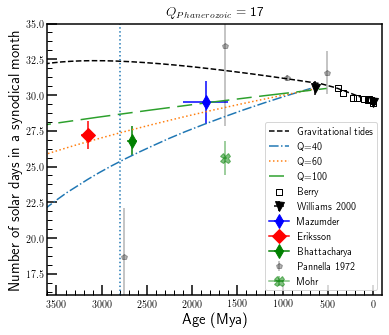

In [53]:
plt.rc('text', usetex=True)
#plt.rc('lines', markeredgwidth=1.5)
plt.rc("axes", lw = 1.5)
fig, ax = plt.subplots(figsize=(6,5)) #Default is 6 wide, 4 high, i.e., figsize = (6,4)
#
#plt.plot(age_x, s_solar_days_5)
#
plt.plot(age_tides_day_40, s_solar_days_47[:len(age_tides_day_40)], ls = '--', \
         color = 'black', label = 'Gravitational tides')
#
#plt.plot(age_tides_day_60, s_solar_days_47[:len(age_tides_day_60)], ls = '--', \
#         color = 'black', label = 'Gravitational tides')
#
# Now the constant day length result
#
plt.plot(age_const_day_40, s_October_14_40, ls = '-.', label = 'Q=40')
plt.plot(age_const_day_60, s_October_14_60, ls = ':', label = 'Q=60')
plt.plot(age_const_day_100, s_October_14_100, dashes=[10, 5, 20, 5], label = 'Q=100')
#plt.plot(age_const_day, s_prime_October_14, ls='--', label = "s'")
#
#Plot the data
#
#Post Cambrian
#
plt.scatter(time_Berry, days_per_synodic_month_Berry_average, marker='s', facecolors='none', \
           edgecolors = 'black', label = 'Berry')
#Pre-Cambrian
#
#Williams provides the age (600Mya) for the Elatina data, so we don't need to use our fit
#
plt.errorbar(x_williams_age, s_solar_days_per_synodic_month_williams, \
             yerr = s_solar_days_per_synodic_month_williams_error,xerr = x_williams_age_error, marker='v', \
             markersize = 9, color = 'black', ls='none', label='Williams 2000')
#
#plot tidal rhythmites from Eriksson & Simpson (2000) Geology v28 831, and
#from Bhattacharaya
#The tidal rhythmites record lunar days, but I am plotting against predictions for solar days,
#so convert lunar to solar days, e.g., add one.
#
plt.errorbar(Mazumder_age, Mazumder_days_per_month+1, \
             yerr = Mazumder_days_per_month_error, xerr = Mazumder_age_error, \
             marker='d', markersize = 10, c='blue', label='Mazumder') #blue pentagon
#plt.errorbar(Eriksson_age, Eriksson_days_per_month+1, \
#             yerr = Eriksson_days_per_month_error, xerr = Eriksson_age_error, \
#             marker='D', c='red', markersize = 10, label='Eriksson') #red diamond
plt.errorbar(Eriksson_age[1], Eriksson_days_per_month[1]+1, \
             yerr = Eriksson_days_per_month_error[1], xerr = Eriksson_age_error[1], \
             marker='D', c='red', markersize = 10, label='Eriksson') #red diamond
plt.errorbar(Bhattacharya_age, Bhattacharya_days_per_month+1, \
             xerr = Bhattacharya_age_error, yerr = Bhattacharya_days_per_month_error,\
             c='green', marker = 'd', markersize = 10, label='Bhattacharya')
#
# Stromatolites
# I will assume that they respond to the solar day rather than the lunar day.
# If that is the case, we don't have to convert to solar days, the counts are solar days
#plt.scatter(Pannella_1972_stromatolites_Scrutton_ages, \
plt.errorbar(Pannella_1972_stromatolites_Scrutton_ages, \
            Pannella_1972_days_per_month_mean_III, \
             yerr = Pannella_1972_days_per_month_mean_III_sys_err, marker='p', c='k', \
            alpha = 0.3, ls = 'none', label='Pannella 1972') #black right facing triangle
#
#print('Pannella =', Pannella_1972_stromatolites_Scrutton_ages, Pannella_1972_days_per_month_mean_III)
#Now the single point from Mohr
#
plt.errorbar(Mohr_age, \
            Mohr_solar_days_per_synodic_month, xerr = Mohr_age_error,\
             yerr = Mohr_solar_days_per_synodic_month_error, marker='X', \
             c='g', markersize = 10, alpha = 0.5, label='Mohr') #green filled X
#
#print('Mohr age and s =', Mohr_age, Mohr_solar_days_per_synodic_month+1)
#
#
plt.axvline(2800, ls = ':')
plt.legend()
#ax.set_aspect(200.) #This changes the aspect ratio of the axes rather than the plot, so don't use
plt.xlim(3600, -100)
plt.ylim(16.0, 35.0)
plt.xlabel(r'Age (Mya)', fontsize = label_fontsize)
plt.ylabel(r'Number of solar days in a synodical month', fontsize = label_fontsize)
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=1.5, direction='in')
ax.tick_params(which='minor', length=5, width=1, direction='in')
#plt.title('$Q_{Precambrian}$ = %i, %i,   $Q_{Phanerozoic}=$ %i'%(Q_Precambrian_60, Q_Precambrian_40, Q_Phanerozoic), \
plt.title('$Q_{Phanerozoic}=$ %i'%Q_Phanerozoic, \
    fontsize = label_fontsize *0.9)
#
filename_days_per_month = 'Fig_days_per_synodic_month_vs_age_three_Q.pdf'
plt.savefig(filename_days_per_month)
plt.show()

In [54]:
Eriksson_age_error

array([74, 74])

## We know both the number of days in a month, as a function of age
## and the number of months per year, so we can calculate the number of days per year

williams days per year = [365.3259228  404.66254404]


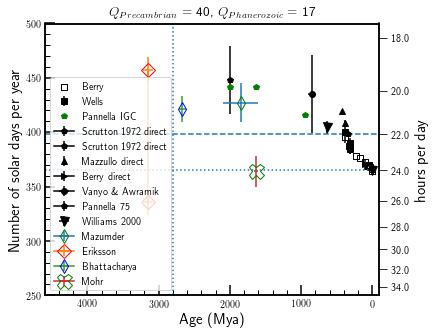

In [55]:
# Find the number of days per year from the number of days per month, plus our curve for a_moon(time)
plt.rc('text', usetex=True)
#plt.rc('lines', markeredgwidth=1.5)
plt.rc("axes", lw = 1.5)
fig, ax = plt.subplots(figsize=(6,5)) #Default is 6 wide, 4 high, i.e., figsize = (6,4)
#
#
current_number_of_sidereal_months_per_year = 13.37  
#Plot the data
#
#
#Wells 1963 Nature
#
plt.errorbar(Wells_time, Wells_days_per_year, yerr = Wells_days_per_year_error,\
            marker = 's', c = 'black', ls = 'none', label = 'Wells')
#
# Stromatolite data is suspect, so we might want to plot it with alpha = 0.2
alpha_stromatolite = 1
#print('Pannella =', Pannella_1972_stromatolites_Scrutton_ages, Pannella_1972_days_per_month_mean_III)
#
# Pannella 1972 International Geological Congress 24 p50-57
#
plt.errorbar(Pannella_IGC_1972_age, Pannella_IGC_1972_days_per_year, \
             marker = 'p', c = 'green', alpha =alpha_stromatolite, ls = 'none', label = 'Pannella IGC')
#
# Pannella 1972 Astrophysics and Space Science vol. 16 212
#
plt.errorbar(Pannella_Aph_Sp_Sc_1972_table_I_pennsylvanian_time[0], \
            Pannella_Aph_Sp_Sc_1972_table_I_pennsylvanian_days_per_year_average, \
             yerr = Pannella_Aph_Sp_Sc_1972_table_I_pennsylvanian_days_per_year_error,\
           marker = 'p', c = 'black', alpha = alpha_stromatolite, label = 'Scrutton 1972 direct')
#
plt.errorbar(Pannella_Aph_Sp_Sc_1972_table_I_mississippian_time[0], \
            Pannella_Aph_Sp_Sc_1972_table_I_mississippian_days_per_year_average, \
             yerr = Pannella_Aph_Sp_Sc_1972_table_I_mississippian_days_per_year_error,\
           marker = 'p', c = 'black', alpha = alpha_stromatolite, label = 'Scrutton 1972 direct')
# print('Pannella direct', Pannella_Aph_Sp_Sc_1972_table_I_mississippian_time, \
#     Pannella_Aph_Sp_Sc_1972_table_I_mississippian_days_per_year_average,\
#       Pannella_Aph_Sp_Sc_1972_table_I_mississippian_days_per_year_error)
#
# Mazzullo
#
plt.errorbar(Mazzullo_corals_brachiopods_time_ave, \
             Mazzullo_corals_brachiopods_days_per_year_ave, \
             yerr = Mazzullo_corals_brachiopods_days_per_year_error,\
            marker = '^', c = 'black', ls = 'none', label = 'Mazzullo direct')
#print('Mazzullo', Mazzullo_corals_brachiopods_time_ave, \
#             Mazzullo_corals_brachiopods_days_per_year_ave)
#
#
# Berry and Barker 68
#
plt.errorbar(Berry_68_time, Berry_68_days_per_year, yerr = Berry_68_days_per_year_error, \
            marker = '>', c = 'black', label = 'Berry direct')
#
#
# Vanyo & Awramik 1985
#
plt.errorbar(Vanyo_Awramik_age, Vanyo_Awramik_days_per_year, \
            xerr = Vanyo_Awramik_age_error, yerr = Vanyo_Awramik_days_per_year_error, \
            marker = 'o', c = 'black', alpha = alpha_stromatolite, markersize = 6, label = 'Vanyo \& Awramik')
#
#
#Pannella 1975 from Rosenberg and Runcorn Growth Rhythmas and the History of the Earth's Rotation
#
plt.errorbar(Pannella_1975_age, Pannella_1975_days_per_year,\
            yerr = Pannella_1975_days_per_year_error, marker = 'p', c = 'black', \
             alpha = alpha_stromatolite, label = 'Pannella 75')
#
#Done with Direct Results
#
#
#Now inferred results, using age to get number of months per year, and then
#multiplying by number of days per month
#
#Post Cambrian
#
#Find the index corresponding to the times in Berry
time_index_Berry = []
for time in time_Berry:
    time_index_Berry.append(np.where(time - Total_T_40 <0)[0][0])

days_per_year_Berry_40 = days_per_synodic_month_Berry_average * \
(current_number_of_sidereal_months_per_year * (a_moon_cgs_0 / Total_a_40[time_index_Berry])**1.5 -1)

plt.scatter(time_Berry, days_per_year_Berry_40, marker='s', facecolors='none', \
           edgecolors = 'black', label = 'Berry')
#Pre-Cambrian
#
#Williams provides the age (600Mya) for the Elatina data, so we don't need to use our fit
#Hence I will use a solid point
#
time_index = []
for time in x_williams_age:
    time_index.append(np.where(time - Total_T_40 <0)[0][0])

williams_days_per_year = s_solar_days_per_synodic_month_williams * \
(current_number_of_sidereal_months_per_year * (a_moon_cgs_0 / Total_a_40[time_index])**1.5 -1)
#
print('williams days per year =', williams_days_per_year)
#

plt.errorbar(x_williams_age, williams_days_per_year, \
             yerr = 12*s_solar_days_per_synodic_month_williams_error, xerr = x_williams_age_error, marker='v', \
             markersize = 9, color = 'black', ls='none', label='Williams 2000')
#
#plot tidal rhythmites from Eriksson & Simpson (2000) Geology v28 831, and
#from Bhattacharaya
#The tidal rhythmites record lunar days, but I am plotting against predictions for solar days,
#so convert lunar to solar days, e.g., add one.
#
time_index_Mazumdar = []
for time in Mazumder_age:
    time_index_Mazumdar.append(np.where(time - Total_T_40 <0)[0][0])

days_per_year_Mazumdar_40 = (Mazumder_days_per_month +1 )* \
(current_number_of_sidereal_months_per_year * (a_moon_cgs_0 / Total_a_40[time_index_Mazumdar])**1.5 -1)

#print('Mazumdar', time_index_Mazumdar, Total_T_60[time_index_Mazumdar], Mazumder_age)

plt.errorbar(Mazumder_age, days_per_year_Mazumdar_40, \
             yerr = 12.*Mazumder_days_per_month_error, xerr = Mazumder_age_error, \
             marker='d', markersize = 10, markerfacecolor = 'none',\
             markeredgecolor = 'green', label='Mazumder') #open green narrow diamond
#
#
time_index = []
for time in Eriksson_age:
    time_index.append(np.where(time - Total_T_40 <0)[0][0])

days_per_year_Eriksson_40 = (Eriksson_days_per_month+1) * \
(current_number_of_sidereal_months_per_year * (a_moon_cgs_0 / Total_a_40[time_index])**1.5 -1)
#
plt.errorbar(Eriksson_age, days_per_year_Eriksson_40, \
             yerr = 12.*Eriksson_days_per_month_error, xerr = Eriksson_age_error, \
             marker='D', markersize = 10, \
             markerfacecolor = 'none', markeredgecolor = 'red', label='Eriksson') #red diamond

#
#
time_index = []
for time in Bhattacharya_age:
    time_index.append(np.where(time - Total_T_40 <0)[0][0])

days_per_year_Bhattacharya_40 = (Bhattacharya_days_per_month +1)* \
(current_number_of_sidereal_months_per_year * (a_moon_cgs_0 / Total_a_40[time_index])**1.5 -1)
#
plt.errorbar(Bhattacharya_age, days_per_year_Bhattacharya_40, \
             xerr = Bhattacharya_age_error, yerr = 12.*Bhattacharya_days_per_month_error,\
              marker = 'd', markersize = 10, markerfacecolor = 'none',
             markeredgecolor = 'blue', label='Bhattacharya')
#
#
#Now the single point from Mohr
#
#
time_index = []
for time in Mohr_age:
    time_index.append(np.where(time - Total_T_40 <0)[0][0])

days_per_year_Mohr_40 = Mohr_solar_days_per_synodic_month * \
(current_number_of_sidereal_months_per_year * (a_moon_cgs_0 / Total_a_40[time_index])**1.5 -1)
#
#
plt.errorbar(Mohr_age, \
            days_per_year_Mohr_40, xerr = Mohr_age_error,\
             yerr = 12.*Mohr_solar_days_per_synodic_month_error, marker='X', \
             markerfacecolor = 'none', markeredgecolor = 'green', \
             markersize = 15, alpha = alpha_stromatolite, label='Mohr') #green unfilled X
#
plt.axvline(2800, ls = ':')
plt.axhline(365.25, ls = ':')
plt.axhline(365.25 * 24./22., ls = '--')
#
plt.legend(loc = 0)
#ax.set_aspect(200.) #This changes the aspect ratio of the axes rather than the plot, so don't use
plt.xlim(4600, -100)
# set ymin and ymax here, so that I can scale the right hand vertical axis appropriately
y_min = 250
y_max = 500
delta_y = y_max - y_min
#
plt.ylim(y_min, y_max)
plt.xlabel(r'Age (Mya)', fontsize = label_fontsize)
plt.ylabel(r'Number of solar days per year', fontsize = label_fontsize)
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=1.5, direction='in')
ax.tick_params(which='minor', length=5, width=1, direction='in')
#
#
# Create the twinned vertical axis
#
# Set the right hand vertical axis in hours per day
#
length_of_year_in_hours = 365.25 * 24 #Solar days and tropical years
#
#
bottom_days, top_days = plt.ylim()
major_tick_locations = np.arange(18,35, 2)
hour_tick_locations = length_of_year_in_hours / (delta_y * major_tick_locations) -1
hour_tick_labels = np.around(length_of_year_in_hours/(y_min + delta_y * hour_tick_locations), decimals = 0)
ax2 = ax.twinx()

#plt.ylim(hours_per_day_bottom, hours_per_day_top)
plt.yticks(hour_tick_locations, hour_tick_labels)
ax2.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
#ax2.minorticks_on()
plt.ylabel(r'hours per day', fontsize = label_fontsize)
#
#
plt.title('$Q_{Precambrian}$ = %i,   $Q_{Phanerozoic}=$ %i'%( Q_Precambrian_40, Q_Phanerozoic), \
          fontsize = label_fontsize *0.9)
filename_days_per_year = 'Fig_days_per_year_vs_age_Q_' + str(int(Q_Precambrian_40)) + '.pdf'
plt.savefig(filename_days_per_year)
plt.show()


In [56]:
print('williams days per year =', williams_days_per_year)
print('Mazumdar days per year =', days_per_year_Mazumdar_40)
print('Bhattacharay days per year =', days_per_year_Bhattacharya_40)
print('Eriksson days per year = ', days_per_year_Eriksson_40)

williams days per year = [365.3259228  404.66254404]
Mazumdar days per year = [427.17139654]
Bhattacharay days per year = [421.56006576]
Eriksson days per year =  [336.25054275 457.30073815]


In [57]:
#do the calculations first, plot in the next cell
# Q = 50
#
current_number_of_sidereal_months_per_year = 13.37  
#
#Post Cambrian
#
#Find the index corresponding to the times in Berry
#Bivalves
#
time_index_Berry = []
for time in time_Berry:
    time_index_Berry.append(np.where(time - Total_T_50 <0)[0][0])

#I think bivalves record the solar day, so don't add 1 to days_per_month
days_per_year_Berry_50 = days_per_synodic_month_Berry_average * \
(current_number_of_sidereal_months_per_year * (a_moon_cgs_0 / Total_a_50[time_index_Berry])**1.5 - 1 )

#
#Williams provides the age (600Mya) for the Elatina data, so we don't need to use our fit
#Hence I will use a solid point
#
#
time_index = []
for time in x_williams_age:
    time_index.append(np.where(time - Total_T_50 <0)[0][0])

williams_days_per_year = s_solar_days_per_synodic_month_williams * \
(current_number_of_sidereal_months_per_year * (a_moon_cgs_0 / Total_a_50[time_index])**1.5 - 1)
print('Williams calculated synodic months per year', \
(current_number_of_sidereal_months_per_year * (a_moon_cgs_0 / Total_a_50[time_index])**1.5 - 1)     )
#
# Tidal Rhythmites from Mazumdar, from Eriksson & Simpson, and from Bhattacharaya
#
time_index_Mazumdar = []
for time in Mazumder_age:
    time_index_Mazumdar.append(np.where(time - Total_T_50 <0)[0][0])

# I think tidal rhythimites record lunar days per synodic month, so add 1
days_per_year_Mazumdar_50 = (Mazumder_days_per_month + 1) * \
(current_number_of_sidereal_months_per_year *(a_moon_cgs_0 / Total_a_50[time_index_Mazumdar])**1.5 - 1)

#
time_index_Eriksson = []
for time in Eriksson_age:
    time_index_Eriksson.append(np.where(time - Total_T_50 <0)[0][0])

days_per_year_Eriksson_50 = (Eriksson_days_per_month+1) * \
(current_number_of_sidereal_months_per_year * (a_moon_cgs_0 / Total_a_50[time_index_Eriksson])**1.5 - 1.)

#
#
time_index_Bhattacharya = []
for time in Bhattacharya_age:
    time_index_Bhattacharya.append(np.where(time - Total_T_50 <0)[0][0])

days_per_year_Bhattacharya_50 = (Bhattacharya_days_per_month - 1) * \
(current_number_of_sidereal_months_per_year * (a_moon_cgs_0 / Total_a_50[time_index_Bhattacharya])**1.5 - 1.)

#
time_index_Mohr = []
for time in Mohr_age:
    time_index_Mohr.append(np.where(time - Total_T_50 <0)[0][0])

days_per_year_Mohr = Mohr_solar_days_per_synodic_month * \
(current_number_of_sidereal_months_per_year * (a_moon_cgs_0 / Total_a_50[time_index_Mohr])**1.5 - 1)
#
#
print('Mazumdar days per year = ', days_per_year_Mazumdar_50)
print('Bhattacharya days per year = ', days_per_year_Bhattacharya_50)
print('Eriksson days per year = ', days_per_year_Eriksson_50)

Williams calculated synodic months per year [12.37134855 13.24422821]
Mazumdar days per year =  [417.70880137]
Bhattacharya days per year =  [372.02396388]
Eriksson days per year =  [312.87831422 425.51450733]


Mazzullo [431.5  389.05] [419.66666667 408.2       ]


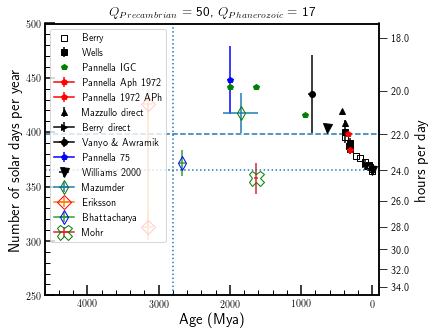

In [58]:
# Find the number of days per year from the number of days per month, plus our curve for a_moon(time)
# Q = 50
plt.rc('text', usetex=True)
#plt.rc('lines', markeredgwidth=1.5)
plt.rc("axes", lw = 1.5)
fig, ax = plt.subplots(figsize=(6,5)) #Default is 6 wide, 4 high, i.e., figsize = (6,4)

#Plot the data
#
# Direct measurements first
#
#Wells 1963 Nature
#
plt.errorbar(Wells_time, Wells_days_per_year, yerr = Wells_days_per_year_error,\
            marker = 's', c = 'black', ls = 'none', label = 'Wells')
#
# Pannella 1972 International Geological Congress 24 p50-57 Stromatolites
#
plt.errorbar(Pannella_IGC_1972_age, Pannella_IGC_1972_days_per_year, \
             marker = 'p', c = 'green', alpha = alpha_stromatolite, ls = 'none', label = 'Pannella IGC')
#
# Pannella 1972 Astrophysics and Space Science, Stormatolites
#
plt.errorbar(Pannella_Aph_Sp_Sc_1972_table_I_pennsylvanian_time[0], \
            Pannella_Aph_Sp_Sc_1972_table_I_pennsylvanian_days_per_year_average, \
             yerr = Pannella_Aph_Sp_Sc_1972_table_I_pennsylvanian_days_per_year_error,\
           marker = 'p', c = 'red', alpha = alpha_stromatolite, label = 'Pannella Aph 1972')
#
plt.errorbar(Pannella_Aph_Sp_Sc_1972_table_I_mississippian_time[0], \
            Pannella_Aph_Sp_Sc_1972_table_I_mississippian_days_per_year_average, \
             yerr = Pannella_Aph_Sp_Sc_1972_table_I_mississippian_days_per_year_error,\
           marker = 'p', c = 'red', alpha = alpha_stromatolite, label = 'Pannella 1972 APh')

#
# Mazzullo corals and brachiopods
#
plt.errorbar(Mazzullo_corals_brachiopods_time_ave, \
             Mazzullo_corals_brachiopods_days_per_year_ave, \
             yerr = Mazzullo_corals_brachiopods_days_per_year_error,\
            marker = '^', c = 'black', ls = 'none', label = 'Mazzullo direct')
print('Mazzullo', Mazzullo_corals_brachiopods_time_ave, \
             Mazzullo_corals_brachiopods_days_per_year_ave)
#
#
# Berry and Barker 68
#
plt.errorbar(Berry_68_time, Berry_68_days_per_year, yerr = Berry_68_days_per_year_error, \
            marker = '>', c = 'black', label = 'Berry direct')
#
#
# Vanyo & Awramik 1985, stromatoloites
#
plt.errorbar(Vanyo_Awramik_age, Vanyo_Awramik_days_per_year, \
            xerr = Vanyo_Awramik_age_error, yerr = Vanyo_Awramik_days_per_year_error, \
            marker = 'o', c = 'black', markersize = 6, alpha = alpha_stromatolite, label = 'Vanyo \& Awramik')
#
#
#Pannella 1975 from Rosenberg and Runcorn Growth Rhythmas and the History of the Earth's Rotation
# stromatolites
plt.errorbar(Pannella_1975_age, Pannella_1975_days_per_year,\
            yerr = Pannella_1975_days_per_year_error, marker = 'p', c = 'blue', \
             alpha = alpha_stromatolite, label = 'Pannella 75')
#
#Done with Direct Results
#
#Now inferred results, using age to get number of months per year, and then
#multiplying by number of days per month
# Use open symbols for this data

#Berry Bivalves
#The 60 refers to the value of Q we are using
#
plt.scatter(time_Berry, days_per_year_Berry_50, marker='s', facecolors='none', \
           edgecolors = 'black', label = 'Berry')
#Pre-Cambrian

#
#
plt.errorbar(x_williams_age, williams_days_per_year, \
             yerr = s_solar_days_per_synodic_month_williams_error,xerr = \
             x_williams_age_error, marker='v', \
             markersize = 9, color = 'black', ls='none', label='Williams 2000')
#
#plot tidal rhythmites from Mazumdar, Eriksson & Simpson (2000) Geology v28 831, and
#from Bhattacharaya
#The tidal rhythmites record lunar days, but I am plotting against predictions for solar days,
#so convert lunar to solar days, e.g., add one.
#
#print('Mazumdar', time_index_Mazumdar, Total_T_50[time_index_Mazumdar], Mazumder_age)

plt.errorbar(Mazumder_age, days_per_year_Mazumdar_50, \
             yerr = 12.*Mazumder_days_per_month_error, xerr = Mazumder_age_error, \
             marker='d', markersize = 10, markerfacecolor = 'none',\
             markeredgecolor = 'green', label='Mazumder') #open green narrow diamond
#
#
plt.errorbar(Eriksson_age, days_per_year_Eriksson_50, \
             yerr = 12.*Eriksson_days_per_month_error, xerr = Eriksson_age_error, \
             marker='D', markersize = 10, \
             markerfacecolor = 'none', markeredgecolor = 'red', label='Eriksson') #red diamond
#
#
plt.errorbar(Bhattacharya_age, days_per_year_Bhattacharya_50, \
             xerr = Bhattacharya_age_error, yerr = 12.*Bhattacharya_days_per_month_error,\
              marker = 'd', markersize = 10, markerfacecolor = 'none',
             markeredgecolor = 'blue', label='Bhattacharya')
#
#
plt.errorbar(Mohr_age, \
            days_per_year_Mohr, xerr = Mohr_age_error,\
             yerr = 12.*Mohr_solar_days_per_synodic_month_error, marker='X', \
             markerfacecolor = 'none', markeredgecolor = 'green', \
             markersize = 15, alpha = alpha_stromatolite, label='Mohr') #green unfilled X
#
plt.axvline(2800, ls = ':')
plt.axhline(365.25, ls = ':')
plt.axhline(365.25 * 24./22., ls = '--')
#

plt.legend()
#ax.set_aspect(200.) #This changes the aspect ratio of the axes rather than the plot, so don't use
plt.xlim(4600, -100)
y_min = 250
y_max = 500
plt.ylim(y_min, y_max)
plt.xlabel(r'Age (Mya)', fontsize = label_fontsize)
plt.ylabel(r'Number of solar days per year', fontsize = label_fontsize)
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=1.5, direction='in')
ax.tick_params(which='minor', length=5, width=1, direction='in')
#
# Create the twinned vertical axis
#
# Set the right hand vertical axis in hours per day
#
length_of_year_in_hours = 365.25 * 24 #Solar days and tropical years
#
#
bottom_days, top_days = plt.ylim()
major_tick_locations = np.arange(18,35, 2)
hour_tick_locations = length_of_year_in_hours / (delta_y * major_tick_locations) -1
hour_tick_labels = np.around(length_of_year_in_hours/(y_min + delta_y * hour_tick_locations), decimals = 0)
ax2 = ax.twinx()

#plt.ylim(hours_per_day_bottom, hours_per_day_top)
plt.yticks(hour_tick_locations, hour_tick_labels)
ax2.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
#ax2.minorticks_on()
plt.ylabel(r'hours per day', fontsize = label_fontsize)
#
#
plt.title('$Q_{Precambrian}$ = %i,   $Q_{Phanerozoic}=$ %i'%( Q_Precambrian_50, Q_Phanerozoic), \
          fontsize = label_fontsize *0.9)
#
filename_days_per_year = 'Fig_days_per_year_vs_age_Q_' + str(int(Q_Precambrian_50)) + '.pdf'
plt.savefig(filename_days_per_year)
plt.show()


In [59]:
#Same as above do the calculations first, this time Q = 60
#
current_number_of_sidereal_months_per_year = 13.37  
#
#Post Cambrian
#
#Find the index corresponding to the times in Berry
#Bivalves
#
time_index_Berry = []
for time in time_Berry:
    time_index_Berry.append(np.where(time - Total_T_60 <0)[0][0])

#I think bivalves record the solar day, so don't add 1 to days_per_month
days_per_year_Berry_60 = days_per_synodic_month_Berry_average * \
(current_number_of_sidereal_months_per_year * (a_moon_cgs_0 / Total_a_60[time_index_Berry])**1.5 - 1 )

#
#Williams provides the age (600Mya) for the Elatina data, so we don't need to use our fit
#Hence I will use a solid point
#
#
time_index = []
for time in x_williams_age:
    time_index.append(np.where(time - Total_T_60 <0)[0][0])

williams_days_per_year = s_solar_days_per_synodic_month_williams * \
(current_number_of_sidereal_months_per_year * (a_moon_cgs_0 / Total_a_60[time_index])**1.5 - 1)
print('Williams calculated synodic months per year', \
(current_number_of_sidereal_months_per_year * (a_moon_cgs_0 / Total_a_60[time_index])**1.5 - 1)     )
#
# Tidal Rhythmites from Mazumdar, from Eriksson & Simpson, and from Bhattacharaya
#
time_index_Mazumdar = []
for time in Mazumder_age:
    time_index_Mazumdar.append(np.where(time - Total_T_60 <0)[0][0])

# I think tidal rhythimites record lunar days per synodic month, so add 1
days_per_year_Mazumdar_60 = (Mazumder_days_per_month + 1) * \
(current_number_of_sidereal_months_per_year *(a_moon_cgs_0 / Total_a_60[time_index_Mazumdar])**1.5 - 1)

#
time_index_Eriksson = []
for time in Eriksson_age:
    time_index_Eriksson.append(np.where(time - Total_T_60 <0)[0][0])

days_per_year_Eriksson_60 = (Eriksson_days_per_month+1) * \
(current_number_of_sidereal_months_per_year * (a_moon_cgs_0 / Total_a_60[time_index_Eriksson])**1.5 - 1.)

#
#
time_index_Bhattacharya = []
for time in Bhattacharya_age:
    time_index_Bhattacharya.append(np.where(time - Total_T_60 <0)[0][0])

days_per_year_Bhattacharya_60 = (Bhattacharya_days_per_month - 1) * \
(current_number_of_sidereal_months_per_year * (a_moon_cgs_0 / Total_a_60[time_index_Bhattacharya])**1.5 - 1.)

#
time_index_Mohr = []
for time in Mohr_age:
    time_index_Mohr.append(np.where(time - Total_T_60 <0)[0][0])

days_per_year_Mohr = Mohr_solar_days_per_synodic_month * \
(current_number_of_sidereal_months_per_year * (a_moon_cgs_0 / Total_a_60[time_index_Mohr])**1.5 - 1)
#
#
print('Mazumdar days per year = ', days_per_year_Mazumdar_60)
print('Bhattacharya days per year = ', days_per_year_Bhattacharya_60)
print('Eriksson days per year = ', days_per_year_Eriksson_60)

Williams calculated synodic months per year [12.37134855 13.22874383]
Mazumdar days per year =  [411.94468796]
Bhattacharya days per year =  [362.01747676]
Eriksson days per year =  [301.04362292 409.41932717]


Mazzullo [431.5  389.05] [419.66666667 408.2       ]
min, max of torque = 1.0965570505161578e+23 3.868204987861e+23
min, max of torque = 6.579342303096905e+22 3.868204987861e+23


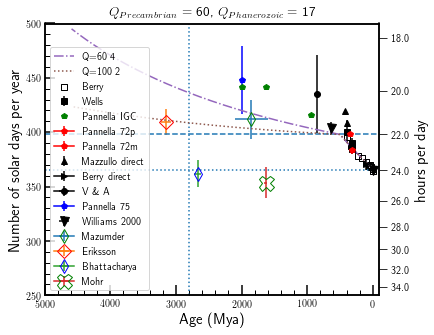

In [60]:
# Find the number of days per year from the number of days per month, plus our curve for a_moon(time)
plt.rc('text', usetex=True)
#plt.rc('lines', markeredgwidth=1.5)
plt.rc("axes", lw = 1.5)
fig, ax = plt.subplots(figsize=(6,5)) #Default is 6 wide, 4 high, i.e., figsize = (6,4)

#Plot the data
#
# Direct measurements first
#
#Wells 1963 Nature
#
plt.errorbar(Wells_time, Wells_days_per_year, yerr = Wells_days_per_year_error,\
            marker = 's', c = 'black', ls = 'none', label = 'Wells')
#
# Pannella 1972 International Geological Congress 24 p50-57 Stromatolites
#
alpha_stromatolite = 1
#
plt.errorbar(Pannella_IGC_1972_age, Pannella_IGC_1972_days_per_year, \
             marker = 'p', c = 'green', alpha = alpha_stromatolite, ls = 'none', label = 'Pannella IGC')
#
# Pannella 1972 Astrophysics and Space Science, Stormatolites
#
plt.errorbar(Pannella_Aph_Sp_Sc_1972_table_I_pennsylvanian_time[0], \
            Pannella_Aph_Sp_Sc_1972_table_I_pennsylvanian_days_per_year_average, \
             yerr = Pannella_Aph_Sp_Sc_1972_table_I_pennsylvanian_days_per_year_error,\
           marker = 'p', c = 'red', alpha = alpha_stromatolite, label = 'Pannella 72p')
#
plt.errorbar(Pannella_Aph_Sp_Sc_1972_table_I_mississippian_time[0], \
            Pannella_Aph_Sp_Sc_1972_table_I_mississippian_days_per_year_average, \
             yerr = Pannella_Aph_Sp_Sc_1972_table_I_mississippian_days_per_year_error,\
           marker = 'p', c = 'red', alpha = alpha_stromatolite, label = 'Pannella 72m')

#
# Mazzullo corals and brachiopods
#
plt.errorbar(Mazzullo_corals_brachiopods_time_ave, \
             Mazzullo_corals_brachiopods_days_per_year_ave, \
             yerr = Mazzullo_corals_brachiopods_days_per_year_error,\
            marker = '^', c = 'black', ls = 'none', label = 'Mazzullo direct')
print('Mazzullo', Mazzullo_corals_brachiopods_time_ave, \
             Mazzullo_corals_brachiopods_days_per_year_ave)
#
#
# Berry and Barker 68
#
plt.errorbar(Berry_68_time, Berry_68_days_per_year, yerr = Berry_68_days_per_year_error, \
            marker = '>', c = 'black', label = 'Berry direct')
#
#
# Vanyo & Awramik 1985, stromatoloites
#
plt.errorbar(Vanyo_Awramik_age, Vanyo_Awramik_days_per_year, \
            xerr = Vanyo_Awramik_age_error, yerr = Vanyo_Awramik_days_per_year_error, \
            marker = 'o', c = 'black', markersize = 6, alpha = alpha_stromatolite, label = 'V \& A')
#
#
#Pannella 1975 from Rosenberg and Runcorn Growth Rhythmas and the History of the Earth's Rotation
# stromatolites
plt.errorbar(Pannella_1975_age, Pannella_1975_days_per_year,\
            yerr = Pannella_1975_days_per_year_error, marker = 'p', c = 'blue', \
             alpha = alpha_stromatolite, label = 'Pannella 75')
#
#Done with Direct Results
#
#Now inferred results, using age to get number of months per year, and then
#multiplying by number of days per month
# Use open symbols for this data

#Berry Bivalves
#The 60 refers to the value of Q we are using
#
plt.scatter(time_Berry, days_per_year_Berry_60, marker='s', facecolors='none', \
           edgecolors = 'black', label = 'Berry')
#Pre-Cambrian

#
#
plt.errorbar(x_williams_age, williams_days_per_year, \
             yerr = 12*s_solar_days_per_synodic_month_williams_error,xerr = \
             x_williams_age_error, marker='v', \
             markersize = 9, color = 'black', ls='none', label='Williams 2000')
#
#plot tidal rhythmites from Mazumdar, Eriksson & Simpson (2000) Geology v28 831, and
#from Bhattacharaya
#The tidal rhythmites record lunar days, but I am plotting against predictions for solar days,
#so convert lunar to solar days, e.g., add one.
#
#print('Mazumdar', time_index_Mazumdar, Total_T_60[time_index_Mazumdar], Mazumder_age)

plt.errorbar(Mazumder_age, days_per_year_Mazumdar_60, \
             yerr = 12.*Mazumder_days_per_month_error, xerr = Mazumder_age_error, \
             marker='d', markersize = 10, markerfacecolor = 'none',\
             markeredgecolor = 'green', label='Mazumder') #open green narrow diamond
#
#
plt.errorbar(Eriksson_age[1], days_per_year_Eriksson_60[1], \
             yerr = 12.*Eriksson_days_per_month_error[1], xerr = Eriksson_age_error[1], \
             marker='D', markersize = 10, \
             markerfacecolor = 'none', markeredgecolor = 'red', label='Eriksson') #red diamond
#
#
plt.errorbar(Bhattacharya_age, days_per_year_Bhattacharya_60, \
             xerr = Bhattacharya_age_error, yerr = 12.*Bhattacharya_days_per_month_error,\
              marker = 'd', markersize = 10, markerfacecolor = 'none',
             markeredgecolor = 'blue', label='Bhattacharya')
#
#
plt.errorbar(Mohr_age, \
            days_per_year_Mohr, xerr = Mohr_age_error,\
             yerr = 12.*Mohr_solar_days_per_synodic_month_error, marker='X', \
             markerfacecolor = 'none', markeredgecolor = 'green', \
             markersize = 15, alpha = alpha_stromatolite, label='Mohr') #green unfilled X
#
plt.axvline(2800, ls = ':')
plt.axhline(365.25, ls = ':')
plt.axhline(365.25 * 24./22., ls = '--')
#
# Integrate the angular momentum equation and plot the result
# use function resonance, which needs the current rotation period as input
# test_resonance = resonance(rotation_period, omega_0, Q_test)
#
resonance_boost = 2.
#
#
lunar_torque_60 = lunar_torque(Total_a_60, Total_Q_60, A_MacDonald)
d_L_Earth_dt_60 = np.zeros(lunar_torque_60.size)
d_L_Earth_dt_60[:index_of_break_age] = -lunar_torque_60[:index_of_break_age] + 2.5e22  #The latter from Zahnle & Walker 1987, doubled
d_L_Earth_dt_60[index_of_break_age:] = -lunar_torque_60[index_of_break_age:] + 2.5e22 * resonance_boost
dt_60 = (Total_T_60[1:] - Total_T_60[:-1]) * year_in_seconds * 1.e6 #My time units are Myrs, I want seconds
integrand_L_Earth_60 = d_L_Earth_dt_60[:-1] * dt_60
L_Earth_history_60 = L_Earth - np.cumsum(integrand_L_Earth_60)
#
length_of_day_60 = 2.*np.pi * I_Earth /L_Earth_history_60 / 3600.
days_per_year_60 = 365.25 * 24. / length_of_day_60
plt.plot(Total_T_60[:-1], days_per_year_60, ls = '-.', label = 'Q=60 4')
print('min, max of torque =', np.min(lunar_torque_60), np.max(lunar_torque_60) )
#
#
lunar_torque_100 = lunar_torque(Total_a_100, Total_Q_100, A_MacDonald)
d_L_Earth_dt_100 = np.zeros(lunar_torque_100.size)
d_L_Earth_dt_100[:index_of_break_age] = -lunar_torque_100[:index_of_break_age] + 2.5e22  #The latter from Zahnle & Walker 1987, doubled
d_L_Earth_dt_100[index_of_break_age:] = -lunar_torque_100[index_of_break_age:] + 2.5e22 * resonance_boost
dt_100 = (Total_T_100[1:] - Total_T_100[:-1]) * year_in_seconds * 1.e6 #My time units are Myrs, I want seconds
integrand_L_Earth_100 = d_L_Earth_dt_100[:-1] * dt_100
L_Earth_history_100 = L_Earth - np.cumsum(integrand_L_Earth_100)
#
length_of_day_100 = 2.*np.pi * I_Earth /L_Earth_history_100 / 3600.
days_per_year_100 = 365.25 * 24. / length_of_day_100
plt.plot(Total_T_100[:-1], days_per_year_100, ls = ':', label = 'Q=100 2')
print('min, max of torque =', np.min(lunar_torque_100), np.max(lunar_torque_100) )
#
#
#
plt.legend()
#ax.set_aspect(200.) #This changes the aspect ratio of the axes rather than the plot, so don't use
plt.xlim(5000, -100)
y_min = 250
y_max = 500
plt.ylim(y_min, y_max)
plt.xlabel(r'Age (Mya)', fontsize = label_fontsize)
plt.ylabel(r'Number of solar days per year', fontsize = label_fontsize)
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=1.5, direction='in')
ax.tick_params(which='minor', length=5, width=1, direction='in')
#
# Create the twinned vertical axis
#
# Set the right hand vertical axis in hours per day
#
length_of_year_in_hours = 365.25 * 24 #Solar days and tropical years
#
#
bottom_days, top_days = plt.ylim()
major_tick_locations = np.arange(18,35, 2)
hour_tick_locations = length_of_year_in_hours / (delta_y * major_tick_locations) -1
hour_tick_labels = np.around(length_of_year_in_hours/(y_min + delta_y * hour_tick_locations), decimals = 0)
ax2 = ax.twinx()

#plt.ylim(hours_per_day_bottom, hours_per_day_top)
plt.yticks(hour_tick_locations, hour_tick_labels)
ax2.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
#ax2.minorticks_on()
plt.ylabel(r'hours per day', fontsize = label_fontsize)
#
#
plt.title('$Q_{Precambrian}$ = %i,   $Q_{Phanerozoic}=$ %i'%( Q_Precambrian_60, Q_Phanerozoic), \
          fontsize = label_fontsize *0.9)
#
filename_days_per_year = 'Fig_days_per_year_vs_age_Q_' + str(int(Q_Precambrian_60)) + '.pdf'
plt.savefig(filename_days_per_year)
plt.show()


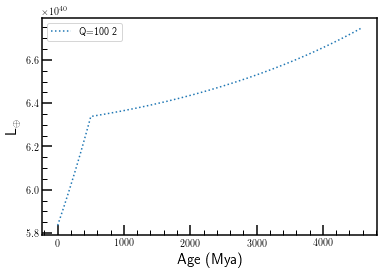

min, max of torque, I_Earth = 6.579342303096905e+22 3.868204987861e+23 8.000659823922366e+44


In [61]:
fig, ax = plt.subplots()
lunar_torque_100 = lunar_torque(Total_a_100, Total_Q_100, A_MacDonald)
d_L_Earth_dt_100 = np.zeros(lunar_torque_100.size)
d_L_Earth_dt_100[:index_of_break_age] = -lunar_torque_100[:index_of_break_age] + 2.5e22  #The latter from Zahnle & Walker 1987, doubled
d_L_Earth_dt_100[index_of_break_age:] = -lunar_torque_100[index_of_break_age:] + 2.5e22 * 2.
dt_100 = (Total_T_100[1:] - Total_T_100[:-1]) * year_in_seconds * 1.e6 #My time units are Myrs, I want seconds
integrand_L_Earth_100 = d_L_Earth_dt_100[:-1] * dt_100
L_Earth_history_100 = L_Earth - np.cumsum(integrand_L_Earth_100)
#
length_of_day_100 = 2.*np.pi * I_Earth /L_Earth_history_100 / 3600.
days_per_year_100 = 365.25 * 24. / length_of_day_100
plt.plot(Total_T_100[:-1], L_Earth_history_100, ls = ':', label = 'Q=100 2')
plt.xlabel(r'Age (Mya)', fontsize = label_fontsize)
plt.ylabel(r'L$_\oplus$', fontsize = label_fontsize)
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=1.5, direction='in')
ax.tick_params(which='minor', length=5, width=1, direction='in')
plt.legend()
plt.show()
print('min, max of torque, I_Earth =', np.min(lunar_torque_100), np.max(lunar_torque_100), I_Earth )

In [62]:
Total_T_100

array([   0,    1,    2, ..., 4585, 4590, 4595])

Current Lunar Torque =  4.5567964663840264e+23


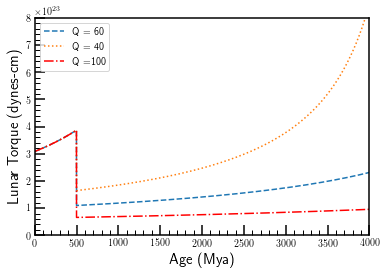

array([3.08254117e+23, 3.08378503e+23, 3.08502994e+23, ...,
       4.27827977e+24, 4.44489832e+24, 4.62563127e+24])

In [63]:
#Plot the lunar torque for our various models, compared to the torque today
fig, ax = plt.subplots()
lunar_torque_60 = lunar_torque(Total_a_60, Total_Q_60, A_MacDonald)
lunar_torque_40 = lunar_torque(Total_a_40, Total_Q_40, A_MacDonald)
lunar_torque_100 = lunar_torque(Total_a_100, Total_Q_100, A_MacDonald)
plt.rc("axes", lw = 1.5)
plt.plot(Total_T_60, lunar_torque_60, ls = '--', label = 'Q = 60')
plt.plot(Total_T_40,  lunar_torque_40, ls = ':', label = 'Q = 40')
plt.plot(Total_T_100,  lunar_torque_100, c = 'red', ls = '-.', label = 'Q =100')
print('Current Lunar Torque = ', Torque_Moon)
plt.xlim(0, 4000)
plt.ylim(1, 8.e23)
plt.xlabel(r'Age (Mya)', fontsize = label_fontsize)
plt.ylabel(r'Lunar Torque (dynes-cm)', fontsize = label_fontsize)
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=1.5, direction='in')
ax.tick_params(which='minor', length=5, width=1, direction='in')
plt.legend()
plt.show()
lunar_torque_40

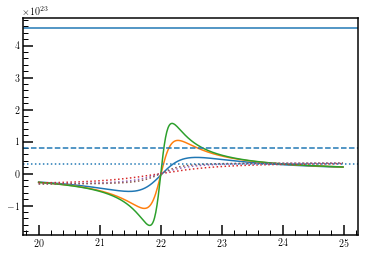

In [64]:
#use odeint to integrate and find S, L
# start by defining the resonance function
#
def res_Bartlett(S_Earth, omega_res, Q_thermal):
    omega = S_Earth/ I_Earth
    top = 4. * omega * (omega**2 - omega_res**2) + omega * omega_res**2/Q_thermal**2
    bottom = 4. * (omega**2 - omega_res**2)**2 + omega**2 * omega_res**2/Q_thermal**2
    return(-top/bottom)

def res_Taylor(S_Earth, omega_res, Q_thermal):
    omega = S_Earth/ I_Earth
    top =   (omega**2 - omega_res**2) 
    bottom =  np.sqrt( (omega**2 - omega_res**2)**2 + omega**2 * omega_res**2/Q_thermal**2 )
    return(-top/bottom)

#test this
#
atmospheric_resonant_period = 22.      # Units are hours, from Hanbo
Q_thermal = 10.                          # Also from Hanbo
#
omega_res = 2. * np.pi / (atmospheric_resonant_period * 3600.)  
S_Earth_0 = L_Earth                   # Fixing my bad naming convention used above

omega_0 = 2. * np.pi / d_sidereal

Torque_th_0 = Torque_Moon / 16.     # Factor 16 is from Bartlett & Stevenson
Normalize_resonance = Torque_th_0 / res_Bartlett(S_Earth_0, omega_res, Q_thermal)
Normalize_resonance_Taylor = Torque_th_0 / res_Taylor(S_Earth_0, omega_res, Q_thermal)

#plot the resonance function over 20-25 hours
#
day_hours = np.arange(20,25,0.01)
day_s = day_hours * 3600.
S_Earth = I_Earth * 2. * np.pi / day_s
#
fig, ax = plt.subplots()
plt.plot(day_hours, Normalize_resonance * res_Bartlett(S_Earth, omega_res, Q_thermal))
plt.plot(day_hours, Normalize_resonance * res_Bartlett(S_Earth, omega_res, 20))
plt.plot(day_hours, Normalize_resonance * res_Bartlett(S_Earth, omega_res, 30))
#
plt.plot(day_hours, Normalize_resonance_Taylor * res_Taylor(S_Earth, omega_res, Q_thermal), ls = ':')
plt.plot(day_hours, Normalize_resonance_Taylor * res_Taylor(S_Earth, omega_res, 20), ls = ':')
plt.plot(day_hours, Normalize_resonance_Taylor * res_Taylor(S_Earth, omega_res, 30), ls = ':')
#
plt.axhline(Torque_Moon_0)
plt.axhline(Torque_Moon_0 * Q_measured / 65., ls = '--')
plt.axhline(Torque_th_0, ls = ':')
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=1.5, direction='in')
ax.tick_params(which='minor', length=5, width=1, direction='in')
plt.show()

In [65]:
Bartlett = res_Bartlett(S_Earth, omega_res, Q_thermal)
Taylor = res_Taylor(S_Earth, omega_res, Q_thermal)
print(Bartlett, Taylor)

[ -62523.82942091  -62815.99554569  -63110.51881268  -63407.42413929
  -63706.73670387  -64008.48194589  -64312.68556609  -64619.3735263
  -64928.57204908  -65240.30761726  -65554.60697305  -65871.49711708
  -66191.00530708  -66513.15905626  -66837.98613149  -67165.51455105
  -67495.7725821   -67828.78873777  -68164.5917739   -68503.21068527
  -68844.67470156  -69189.01328268  -69536.25611372  -69886.43309935
  -70239.57435767  -70595.71021345  -70954.87119081  -71317.08800521
  -71682.39155473  -72050.81291061  -72422.38330709  -72797.13413032
  -73175.09690645  -73556.30328878  -73940.78504395  -74328.57403705
  -74719.7022157   -75114.20159288  -75512.10422857  -75913.44221016
  -76318.24763133  -76726.55256963  -77138.3890624   -77553.78908117
  -77972.78450419  -78395.40708732  -78821.68843283  -79251.65995627
  -79685.35285114  -80122.79805128  -80564.0261909   -81009.067562
  -81457.95206915  -81910.70918139  -82367.3678812   -82827.95661021
  -83292.50321157  -83761.03486885  -

In [66]:
#Define the right hand side of the evolution equations
#
def torques(y, t, N_res, T_0, L_0, beta, omega_res, Q_thermal, Q_Phanerozoic, Q_Precambrian):
    S_Earth, L_Moon = y
    l = L_Moon / L_0
    T_1 = T_0 * Q_measured / Q_Phanerozoic
    #print('L_moon = ', L_Moon, 'L_0 = ', L_0, 'l = ', l)
    if (t > -540*3.15e13) :
        dydt = [N_res * res_Bartlett(S_Earth, omega_res, Q_thermal) - T_1 / l**(12) * (1. + beta * l**12),\
           T_1 / l**(12) ]
    else:
        dydt = [N_res * res_Bartlett(S_Earth, omega_res, Q_thermal) - T_0 / l**(12) * (1. + beta * l**12) *\
                Q_measured / Q_Precambrian,\
               T_0 / l**(12) * Q_measured / Q_Precambrian]
        #print('t = ', t/(3.15e13), Q_Phanerozoic, Q_Precambrian)
    return(dydt)


In [67]:
# Now integrate forward in time
#
#From Figure 2 in the paper
#
initial_t = -3000
initial_a = 3.5e10
#
#From Figure 4, the length of day in hours
initial_P = 19.0   # In hours
#
S_Earth_age_3000 = 2. * np.pi * I_Earth / (initial_P * 3600.)
L_Moon_age_3000  = L_Moon_0 * np.sqrt(initial_a / a_moon_cgs_0)
a_Moon_age_3000  = a_moon_cgs_0 * (L_Moon_age_3000 / L_Moon_0)**2
#print('a at 3000 Gya = ', a_Moon_age_3000/1.e10)
#
#
# Set the initial conditions, namely the Earth's spin angular momentum and the Moons orbital L
#
y0 = [S_Earth_age_3000, L_Moon_age_3000]
#
# Set the times to evaluate at
#
Cambrian = -540
Present = 0
t_Precambrian = np.linspace(initial_t, Cambrian, np.abs(initial_t)) * 3.15e7 * 1.e6   # Million year steps, units of seconds
t_Phanerozoic = np.linspace(Cambrian, Present, np.abs(Cambrian)) * 3.15e7 * 1.e6   # Million year steps, units of seconds
#
#Make sure beta is the correct value
beta = 1./4.7
#
Q_thermal_forward = 15.
Q_thermal_forward_40 = 40.
Q_Precambrian = 55.
Q_Phanerozoic = 17.
#
solution_Precambrian_Q_th_15 = odeint(torques, y0, t_Precambrian, \
                              args = (Normalize_resonance, Torque_Moon_0,\
                                      L_Moon_0, beta, omega_res, Q_thermal_forward, Q_Phanerozoic, Q_Precambrian))
solution_Precambrian_Q_th_40 = odeint(torques, y0, t_Precambrian, \
                              args = (Normalize_resonance, Torque_Moon_0,\
                                      L_Moon_0, beta, omega_res, Q_thermal_forward_40, Q_Phanerozoic, Q_Precambrian))

In [68]:
#Use the end of the Precambrian, and the corresponding S and L, as the initial conditions for the Phanerozoic
#
y0[0] = solution_Precambrian_Q_th_15[-1,0]
y0[1] = solution_Precambrian_Q_th_15[-1,1]
#
#Integrate to the present
#
solution_Phanerozoic_Q_th_15 = odeint(torques, y0, t_Phanerozoic, \
                              args = (Normalize_resonance, Torque_Moon_0,\
                                      L_Moon_0, beta, omega_res, Q_thermal_forward, Q_Phanerozoic, Q_Precambrian))
#
y0[0] = solution_Precambrian_Q_th_40[-1,0]
y0[1] = solution_Precambrian_Q_th_40[-1,1]
solution_Phanerozoic_Q_th_40 = odeint(torques, y0, t_Phanerozoic, \
                              args = (Normalize_resonance, Torque_Moon_0,\
                                      L_Moon_0, beta, omega_res, Q_thermal_forward_40, Q_Phanerozoic, Q_Precambrian))

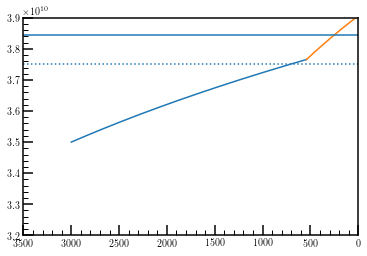

In [69]:
S_Earth_age_Precambrian_Q_th_15 = solution_Precambrian_Q_th_15[:, 0]
L_Moon_age_Precambrian_Q_th_15  = solution_Precambrian_Q_th_15[:, 1]
S_Earth_age_Phanerozoic_Q_th_15 = solution_Phanerozoic_Q_th_15[:, 0]
L_Moon_age_Phanerozoic_Q_th_15 = solution_Phanerozoic_Q_th_15[:, 1]
#
#
lod_Precambrian_Q_th_15 = 2. * np.pi * I_Earth / S_Earth_age_Precambrian_Q_th_15 / d_sidereal * 24.
lod_Phanerozoic_Q_th_15 = 2. * np.pi * I_Earth / S_Earth_age_Phanerozoic_Q_th_15 / d_sidereal * 24.
#
a_Precambrian_Q_th_15 = a_moon_cgs_0 * (L_Moon_age_Precambrian_Q_th_15 / L_Moon_0)**2
a_Phanerozoic_Q_th_15 = a_moon_cgs_0 * (L_Moon_age_Phanerozoic_Q_th_15 / L_Moon_0)**2
#
t_Precambrian_Myrs = t_Precambrian / 3.15e13 
t_Phanerozoic_Myrs = t_Phanerozoic / 3.15e13

fig, ax = plt.subplots()
plt.plot(-t_Precambrian_Myrs, a_Precambrian_Q_th_15)
plt.plot(-t_Phanerozoic_Myrs, a_Phanerozoic_Q_th_15)
plt.ylim(3.2e10, 3.9e10)
plt.xlim(3500, 0)
plt.axhline(3.75e10, ls = ':')
plt.axhline(a_moon_cgs_0)
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=1.5, direction='in')
ax.tick_params(which='minor', length=5, width=1, direction='in')
plt.show()

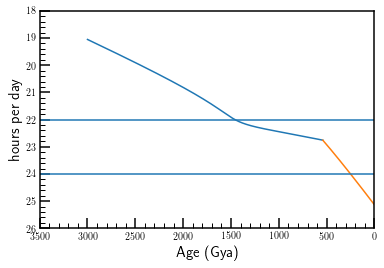

In [70]:

#
fig, ax = plt.subplots()
plt.plot(-t_Precambrian_Myrs, lod_Precambrian_Q_th_15)
plt.plot(-t_Phanerozoic_Myrs, lod_Phanerozoic_Q_th_15)
#
plt.xlabel(r'Age (Gya)', fontsize = label_fontsize)
plt.ylabel(r'hours per day', fontsize = label_fontsize)
#
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=1.5, direction='in')
ax.tick_params(which='minor', length=5, width=1, direction='in')
plt.axhline(24)
plt.axhline(22)
plt.ylim(26., 18.)
plt.xlim(3500, 0)
plt.show()

In [71]:
#We have S and L(t), so now calculate T(t) for both Earth and the Moon
#
#Precambrian first
#
T_Earth_15 = []
T_Lunar_15 = []
for i in range(0, len(t_Precambrian)):
    y = solution_Precambrian_Q_th_15[i,:]
    test = torques(y, t_Precambrian[i], Normalize_resonance, Torque_Moon_0,\
                                      L_Moon_0, beta, omega_res, Q_thermal_forward, Q_Phanerozoic, Q_Precambrian)
    T_Earth_15 = np.append(T_Earth_15, test[0])
    T_Lunar_15 = np.append(T_Lunar_15, test[1])
    
for i in range(0, len(t_Phanerozoic)):
    y = solution_Phanerozoic_Q_th_15[i,:]
    test = torques(y, t_Phanerozoic[i], Normalize_resonance, Torque_Moon_0,\
                                      L_Moon_0, beta, omega_res, Q_thermal_forward, Q_Phanerozoic, Q_Precambrian)
    T_Earth_15 = np.append(T_Earth_15, test[0])
    T_Lunar_15 = np.append(T_Lunar_15, test[1])

t_all = np.append(t_Precambrian_Myrs, t_Phanerozoic_Myrs)

In [72]:
T_Earth_40 = []
T_Lunar_40 = []
for i in range(0, len(t_Precambrian)):
    y = solution_Precambrian_Q_th_40[i,:]
    test = torques(y, t_Precambrian[i], Normalize_resonance, Torque_Moon_0,\
                                      L_Moon_0, beta, omega_res, Q_thermal_forward_40, Q_Phanerozoic, Q_Precambrian)
    T_Earth_40 = np.append(T_Earth_40, test[0])
    T_Lunar_40 = np.append(T_Lunar_40, test[1])
    
for i in range(0, len(t_Phanerozoic)):
    y = solution_Phanerozoic_Q_th_40[i,:]
    test = torques(y, t_Phanerozoic[i], Normalize_resonance, Torque_Moon_0,\
                                      L_Moon_0, beta, omega_res, Q_thermal_forward_40, Q_Phanerozoic, Q_Precambrian)
    T_Earth_40 = np.append(T_Earth_40, test[0])
    T_Lunar_40 = np.append(T_Lunar_40, test[1])


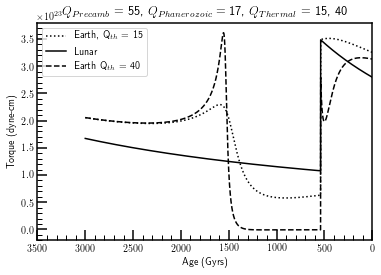

In [73]:
fig, ax = plt.subplots()
#
plt.plot(-t_all, -T_Earth_15, ls = ':', label = 'Earth, Q$_{\r th}$ = 15', c = 'black')
plt.plot(-t_all, T_Lunar_15, label = 'Lunar', c = 'black')
#
plt.plot(-t_all, -T_Earth_40, ls = '--', label = 'Earth Q$_{\r th}$ = 40', c = 'black')
#plt.plot(-t_all, T_Lunar_40, ls = '-.', label = 'Lunar', c = 'black') #redundant, since it is same as Q_th = 15
#
plt.xlim(3500, 0)
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=1.5, direction='in')
ax.tick_params(which='minor', length=5, width=1, direction='in')
plt.ylim(-2.e22)
plt.xlabel(r'Age (Gyrs)')
plt.ylabel(r'Torque (dyne-cm)')
plt.legend()
plt.title('$Q_{Precamb}$ = %i, $Q_{Phanerozoic}=$ %i, $Q_{Thermal}=$ %i, %i'%( Q_Precambrian, Q_Phanerozoic, \
                                                                          Q_thermal_forward, Q_thermal_forward_40), \
          fontsize = label_fontsize *0.85)
filename = 'Fig_T_vs_age_Q_' + str(int(Q_Precambrian)) + '_Qth_' + \
    str(int(Q_thermal_forward)) + '_' + str(int(Q_thermal_forward_40)) + '.pdf'
plt.savefig(filename)
plt.show()